<a href="https://colab.research.google.com/github/rishiiCoder/chemvae/blob/main/MolVAEProgress.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

IMPORTS

In [1]:
!pip install xgboost rdkit pandas scikit-learn pickle-mixin

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.3/34.3 MB 18.2 MB/s eta 0:00:00
  Created wheel for pickle-mixin: filename=pickle_mixin-1.0.2-py3-none-any.whl size=5990 sha256=0585122eacb2e5075df96e554bd7beaf512ae66959c24ab67b6167b47c7313a0
  Stored in directory: /root/.cache/pip/wheels/d0/9c/0d/8709be17c02b72bf04ea60d8ec64fc46a1554c0fb81e048dd6
Successfully built pickle-mixin


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
import gzip
import pandas
import h5py
import numpy as np
from __future__ import print_function
import argparse
import os
import h5py
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn import model_selection

In [3]:
from rdkit import Chem
from rdkit.Chem import RDConfig
from rdkit import Chem
from rdkit.Chem import RDConfig
import os
import sys
sys.path.append(os.path.join(RDConfig.RDContribDir, 'SA_Score'))

In [30]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


DATA PREPROCESSING FILE CREATION

In [5]:
import h5py
import numpy as np
import pandas as pd
import os
import json

max_smiles_len = 42
original_csv = 'drive/My Drive/data/rishimolecules.csv'


def csv_to_ohe_csv(smiles_df, data_signature, charset, max_smiles_len=max_smiles_len, dataset_type='train'):

    df = smiles_df

    # Save one-hot encoded CSVs for train and test
    num_chars = len(charset)
    total_rows = len(df) * max_smiles_len

    # Preallocate a large numpy array
    ohe_array = np.zeros((total_rows, num_chars), dtype=np.float32)

    # Build the index for characters in charset
    char_to_index = {char: i for i, char in enumerate(charset)}

    # Fill the array
    row_idx = 0
    for smiles in df['Smiles']:
        padded_smiles = smiles + ' ' * (max_smiles_len - len(smiles))
        for char in padded_smiles:
            if char in charset:
                ohe_array[row_idx, char_to_index[char]] = 1.0
            row_idx += 1
            if row_idx >= total_rows:  # Safety check to prevent out-of-bounds access
                break
        if row_idx >= total_rows:  # Break the outer loop if limit is reached
            break

    # Convert the numpy array to DataFrame and save
    ohe_df = pd.DataFrame(ohe_array, columns=range(num_chars))
    ohe_csvfile = f'drive/My Drive/data/ohe_data_{dataset_type}_{data_signature}.csv'
    ohe_df.to_csv(ohe_csvfile, index=False)
    print(f"Saved one-hot encoded CSV to {ohe_csvfile}")


def ohe_csvs_to_h5(data_signature):
    ohe_csvfiles = [f'drive/My Drive/data/charset_{data_signature}.csv',
                    f'drive/My Drive/data/ohe_data_train_{data_signature}.csv',
                    f'drive/My Drive/data/ohe_data_test_{data_signature}.csv']

    metadata_file = f'drive/My Drive/data/metadata_{data_signature}.json'
    # Load metadata for reshaping
    with open(metadata_file, 'r') as meta_file:
        metadata = json.load(meta_file)

    h5file = os.path.join(f'drive/My Drive/data/processed_{data_signature}.h5')
    with h5py.File(h5file, 'w') as f:
        for csv in ohe_csvfiles:
            if 'charset' in csv:
                key = 'charset'
            if 'data_train' in csv:
                key = 'data_train'
            if 'data_test' in csv:
                key = 'data_test'
            print(f"Processing key: {key}")

            # Load CSV
            df = pd.read_csv(csv, header=None if key == "charset" else 0)

            if key == "charset":
                # Encode charset as fixed-size byte strings
                data = df.iloc[0].astype(str).apply(lambda x: x.encode('utf-8')).to_numpy(dtype="S1")
            else:
                # Load data as float32 for other datasets
                data = df.to_numpy(dtype=np.float32)
                original_shape = tuple(metadata[key]['original_shape'])
                data = data.reshape(original_shape)

            # Save dataset
            f.create_dataset(key, data=data)
            print(f"Saved {key} to {h5file}, shape: {data.shape}")


def original_csv_to_ohe_h5(original_csv, max_smiles_len=max_smiles_len, charset=None):
    df = pd.read_csv(original_csv)

    # save a copy of full.csv without records that have smiles longer than max_smiles_len
    df = df[df['Smiles'].str.len() < max_smiles_len]

    if charset is None:
        charset = sorted(set(''.join([' '] + list(df['Smiles']))))

    data_len = len(df)
    print(f'original data length: {data_len}')

    train_len = int(len(df)*0.8)
    print(f'train length: {train_len}')

    test_len = len(df) - train_len
    print(f'test length: {test_len}')

    charset_len = len(charset)
    print(f'charset length: {len(charset)}')

    data_signature = f'{data_len}_{max_smiles_len}_{charset_len}'
    print(f'data signature: {data_signature}')

    # Save charset
    pd.DataFrame([charset]).to_csv(f'drive/My Drive/data/charset_{data_signature}.csv', index=False, header=False)

    # Save full csv
    df.to_csv(f'drive/My Drive/data/full_{max_smiles_len}_len.csv', index=False)

    # Shuffle Data
    df = df.sample(frac=1, random_state=42).reset_index(drop=True)

    # make metadata file for the new csv
    metadata = {}
    metadata['charset'] = {'original_shape': [charset_len, 1]}
    metadata['data_train'] = {'original_shape': [train_len, max_smiles_len, charset_len]}
    metadata['data_test'] = {'original_shape': [test_len, max_smiles_len, charset_len]}
    with open(f'drive/My Drive/data/metadata_{data_signature}.json', 'w') as f:
        json.dump(metadata, f)

    # make data_train.csv
    train_df = df.iloc[:train_len]
#    train_df.to_csv(f'data/data_train_{data_signature}.csv', index=False, header=True)

    # make data_test.csv
    test_df = df.iloc[train_len:]
#    test_df.to_csv(f'data/data_test_{data_signature}.csv', index=False, header=True)

    # Save one-hot encoded CSVs for train and test
    csv_to_ohe_csv(train_df, data_signature, charset, max_smiles_len, dataset_type='train')
    csv_to_ohe_csv(test_df, data_signature, charset, max_smiles_len, dataset_type='test')

    # make h5 file
    ohe_csvs_to_h5(data_signature)

    # close file that was open for writing
    f.close()


    # return file path
    return f'drive/My Drive/data/processed_{data_signature}.h5'

def main(original_csv=original_csv):
    original_csv_to_ohe_h5(original_csv, max_smiles_len=max_smiles_len)

if __name__ == '__main__':
    main()

original data length: 1616
train length: 1292
test length: 324
charset length: 41
data signature: 1616_42_41


KeyboardInterrupt: 

**NEW**: H5 File generation for filtered csv file, won't work until the csv file generation is done which is at the bottom of the notebook on the first test_data call

In [89]:
import h5py
import numpy as np
import pandas as pd
import os
import json

max_smiles_len = 42
original_csv = 'drive/My Drive/data/updated_filtered_with_generated.csv'


def csv_to_ohe_csv(smiles_df, data_signature, charset, max_smiles_len=max_smiles_len, dataset_type='train'):

    df = smiles_df

    # Save one-hot encoded CSVs for train and test
    num_chars = len(charset)
    total_rows = len(df) * max_smiles_len

    # Preallocate a large numpy array
    ohe_array = np.zeros((total_rows, num_chars), dtype=np.float32)

    # Build the index for characters in charset
    char_to_index = {char: i for i, char in enumerate(charset)}

    # Fill the array
    row_idx = 0
    for smiles in df['Smiles']:
        padded_smiles = smiles + ' ' * (max_smiles_len - len(smiles))
        for char in padded_smiles:
            if char in charset:
                ohe_array[row_idx, char_to_index[char]] = 1.0
            row_idx += 1
            if row_idx >= total_rows:  # Safety check to prevent out-of-bounds access
                break
        if row_idx >= total_rows:  # Break the outer loop if limit is reached
            break

    # Convert the numpy array to DataFrame and save
    ohe_df = pd.DataFrame(ohe_array, columns=range(num_chars))
    ohe_csvfile = f'drive/My Drive/data/ohe_data_{dataset_type}_{data_signature}.csv'
    ohe_df.to_csv(ohe_csvfile, index=False)
    print(f"Saved one-hot encoded CSV to {ohe_csvfile}")


def ohe_csvs_to_h5(data_signature):
    ohe_csvfiles = [f'drive/My Drive/data/charset_{data_signature}.csv',
                    f'drive/My Drive/data/ohe_data_train_{data_signature}.csv',
                    f'drive/My Drive/data/ohe_data_test_{data_signature}.csv']

    metadata_file = f'drive/My Drive/data/metadata_{data_signature}.json'
    # Load metadata for reshaping
    with open(metadata_file, 'r') as meta_file:
        metadata = json.load(meta_file)

    h5file = os.path.join(f'drive/My Drive/data/processed_{data_signature}.h5')
    with h5py.File(h5file, 'w') as f:
        for csv in ohe_csvfiles:
            if 'charset' in csv:
                key = 'charset'
            if 'data_train' in csv:
                key = 'data_train'
            if 'data_test' in csv:
                key = 'data_test'
            print(f"Processing key: {key}")

            # Load CSV
            df = pd.read_csv(csv, header=None if key == "charset" else 0)

            if key == "charset":
                # Encode charset as fixed-size byte strings
                data = df.iloc[0].astype(str).apply(lambda x: x.encode('utf-8')).to_numpy(dtype="S1")
            else:
                # Load data as float32 for other datasets
                data = df.to_numpy(dtype=np.float32)
                original_shape = tuple(metadata[key]['original_shape'])
                data = data.reshape(original_shape)

            # Save dataset
            f.create_dataset(key, data=data)
            print(f"Saved {key} to {h5file}, shape: {data.shape}")


def original_csv_to_ohe_h5(original_csv, max_smiles_len=max_smiles_len, charset=None):
    df = pd.read_csv(original_csv)

    # save a copy of full.csv without records that have smiles longer than max_smiles_len
    df = df[df['Smiles'].str.len() < max_smiles_len]

    if charset is None:
        charset = sorted(set(''.join([' '] + list(df['Smiles']))))

    data_len = len(df)
    print(f'original data length: {data_len}')

    train_len = int(len(df)*0.8)
    print(f'train length: {train_len}')

    test_len = len(df) - train_len
    print(f'test length: {test_len}')

    charset_len = len(charset)
    print(f'charset length: {len(charset)}')

    data_signature = f'{data_len}_{max_smiles_len}_{charset_len}'
    print(f'data signature: {data_signature}')

    # Save charset
    pd.DataFrame([charset]).to_csv(f'drive/My Drive/data/charset_{data_signature}.csv', index=False, header=False)

    # Save full csv
    df.to_csv(f'drive/My Drive/data/full_{max_smiles_len}_len.csv', index=False)

    # Shuffle Data
    df = df.sample(frac=1, random_state=42).reset_index(drop=True)

    # make metadata file for the new csv
    metadata = {}
    metadata['charset'] = {'original_shape': [charset_len, 1]}
    metadata['data_train'] = {'original_shape': [train_len, max_smiles_len, charset_len]}
    metadata['data_test'] = {'original_shape': [test_len, max_smiles_len, charset_len]}
    with open(f'drive/My Drive/data/metadata_{data_signature}.json', 'w') as f:
        json.dump(metadata, f)

    # make data_train.csv
    train_df = df.iloc[:train_len]
#    train_df.to_csv(f'data/data_train_{data_signature}.csv', index=False, header=True)

    # make data_test.csv
    test_df = df.iloc[train_len:]
#    test_df.to_csv(f'data/data_test_{data_signature}.csv', index=False, header=True)

    # Save one-hot encoded CSVs for train and test
    csv_to_ohe_csv(train_df, data_signature, charset, max_smiles_len, dataset_type='train')
    csv_to_ohe_csv(test_df, data_signature, charset, max_smiles_len, dataset_type='test')

    # make h5 file
    ohe_csvs_to_h5(data_signature)

    # close file that was open for writing
    f.close()


    # return file path
    return f'drive/My Drive/data/processed_{data_signature}.h5'

def main(original_csv=original_csv):
    original_csv_to_ohe_h5(original_csv, max_smiles_len=max_smiles_len)

if __name__ == '__main__':
    main()

original data length: 5470
train length: 4376
test length: 1094
charset length: 47
data signature: 5470_42_47
Saved one-hot encoded CSV to drive/My Drive/data/ohe_data_train_5470_42_47.csv
Saved one-hot encoded CSV to drive/My Drive/data/ohe_data_test_5470_42_47.csv
Processing key: charset
Saved charset to drive/My Drive/data/processed_5470_42_47.h5, shape: (47,)
Processing key: data_train
Saved data_train to drive/My Drive/data/processed_5470_42_47.h5, shape: (4376, 42, 47)
Processing key: data_test
Saved data_test to drive/My Drive/data/processed_5470_42_47.h5, shape: (1094, 42, 47)


In [6]:
# Load from a checkpoint if wanted
LOAD_FROM_CHECKPOINT = True
RUN_ON_TEST_DATA = True
GENERATE_LATENT_SPACE_SMILES = True
EVAL_OTHER_SMILES = True

# Needed for training the model, or, if loading from a checkpoint, to know the charset, data_test, etc.
data_file_to_load_from = 'drive/My Drive/data/processed_1616_42_41.h5'

# Checkpoint and data file should have matching data signatures
# If you change the model (layer sizes, etc.) the checkpoints may not load if they don't match
# Only used if loading from checkpoint file is True
checkpoint_path = 'drive/My Drive/data/checkpoints/3500_checkpoint_1616_42_41.pt'

checkpoint_frequency = 10

epochs = 3500 # 10000 on a100 gpu is good


In [7]:
checkpoint_signature = '_'.join(checkpoint_path.split('.')[-2].split('/')[-1].split('_')[2:])
data_file_signature = '_'.join(data_file_to_load_from.split('.')[-2].split('/')[-1].split('_')[1:])

data_signature = data_file_signature if LOAD_FROM_CHECKPOINT else checkpoint_signature
print(f'Data signature: {data_signature}')

input_len = int(data_signature.split('_')[1])
charset_len = int(data_signature.split('_')[2])
print(f'Input length: {input_len}, Charset length: {charset_len}')

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')
torch.manual_seed(42)

Data signature: 1616_42_41
Input length: 42, Charset length: 41
Using device: cpu


ONE HOT ENCODING

In [8]:
def one_hot_array(i, n):
    return map(int, [ix == i for ix in range(n)])

def one_hot_index(vec, charset):
    return map(charset.index, vec)

def from_one_hot_array(vec):
    oh = np.where(vec == 1)
    if oh[0].shape == (0, ):
        return None
    return int(oh[0][0])

def decode_smiles_from_indexes(vec, charset):
    return "".join(map(lambda x: charset[x], vec)).strip()

def load_dataset(filename, split = True):
    h5f = h5py.File(filename, 'r')
    data_train = h5f['data_train'][:]
    data_test = h5f['data_test'][:]
    if not split:
        # data_test is combined data_test and data_train
        data_test = np.concatenate((data_test, data_train), axis=0)
        data_train = None

    charset =  h5f['charset'][:]
    h5f.close()

    charset = [ch.decode("utf-8") if isinstance(ch, bytes) else ch for ch in charset]


    if split:
        return (data_train, data_test, charset)
    else:
        return (data_test, charset)

**NEW** : Model for Predicting Bioactivities of Protein0 Uses New Scaled Dataset

Filtered dataset shape: (3517, 8)
Training and Testing data shapes: (2813, 2048), (704, 2048), (2813,), (704,)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:723: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	eval-rmse:0.36740
[1]	eval-rmse:0.36575
[2]	eval-rmse:0.36451
[3]	eval-rmse:0.36370
[4]	eval-rmse:0.36275
[5]	eval-rmse:0.36244
[6]	eval-rmse:0.36155
[7]	eval-rmse:0.36057
[8]	eval-rmse:0.36007
[9]	eval-rmse:0.35992
[10]	eval-rmse:0.35924
[11]	eval-rmse:0.35869
[12]	eval-rmse:0.35814
[13]	eval-rmse:0.35801
[14]	eval-rmse:0.35741
[15]	eval-rmse:0.35721
[16]	eval-rmse:0.35682
[17]	eval-rmse:0.35613
[18]	eval-rmse:0.35605
[19]	eval-rmse:0.35558
[20]	eval-rmse:0.35528
[21]	eval-rmse:0.35473
[22]	eval-rmse:0.35451
[23]	eval-rmse:0.35393
[24]	eval-rmse:0.35349
[25]	eval-rmse:0.35353
[26]	eval-rmse:0.35363
[27]	eval-rmse:0.35341
[28]	eval-rmse:0.35339
[29]	eval-rmse:0.35293
[30]	eval-rmse:0.35289
[31]	eval-rmse:0.35259
[32]	eval-rmse:0.35241
[33]	eval-rmse:0.35239
[34]	eval-rmse:0.35205
[35]	eval-rmse:0.35175
[36]	eval-rmse:0.35122
[37]	eval-rmse:0.35126
[38]	eval-rmse:0.35118
[39]	eval-rmse:0.35083
[40]	eval-rmse:0.35057
[41]	eval-rmse:0.35032
[42]	eval-rmse:0.35052
[43]	eval-rmse:0.3505

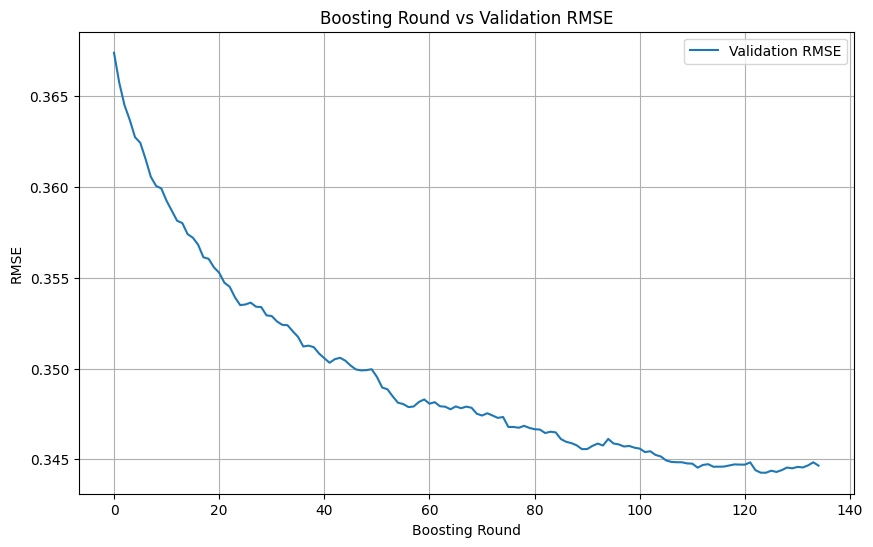

<Figure size 1000x600 with 0 Axes>

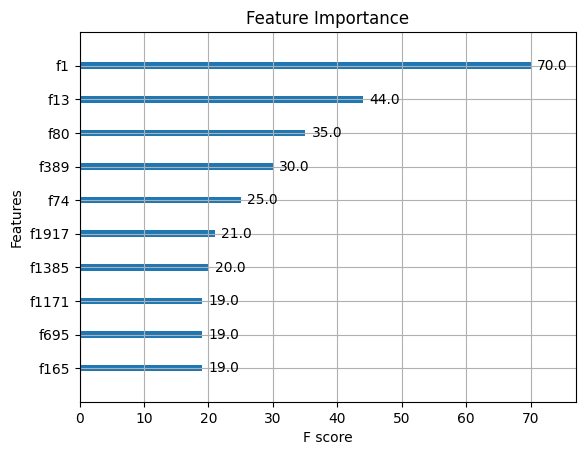

Root Mean Squared Error (RMSE): 0.3446501888268561


In [32]:
import torch
import xgboost as xgb
import rdkit
import pandas as pd
from sklearn.model_selection import train_test_split
from rdkit import Chem
from rdkit.Chem import rdMolDescriptors
import numpy as np
from sklearn.metrics import mean_squared_error
import pickle
import matplotlib.pyplot as plt


data_path = '/content/drive/My Drive/data/cleaned_dataset_minmax.csv'
df = pd.read_csv(data_path)
df.head()

# filter to only be part of dataset that contains kinase 0 molecules
df_filtered = df[df['Kinase'] == 0]

print(f"Filtered dataset shape: {df_filtered.shape}")
df_filtered.head()

# convert molecule SMILES to morgan fingerprints for XGBoost
def smiles_to_fingerprint(smiles, radius=2, nBits=2048):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        fingerprint = rdMolDescriptors.GetMorganFingerprintAsBitVect(mol, radius, nBits)
        return np.array(fingerprint)
    else:
        return np.zeros(nBits)

fingerprints = df_filtered['Smiles'].apply(smiles_to_fingerprint)

X_filtered = np.array(fingerprints.tolist())

# setting bioactivities as target column
y_filtered = df_filtered['Bioactivities']

X_train, X_test, y_train, y_test = train_test_split(X_filtered, y_filtered, test_size=0.2, random_state=42)

print(f"Training and Testing data shapes: {X_train.shape}, {X_test.shape}, {y_train.shape}, {y_test.shape}")

# data converts to xgb d matrix, specific usage for Xgboost
train_data = xgb.DMatrix(X_train, label=y_train)
test_data = xgb.DMatrix(X_test, label=y_test)

params = {
    'objective': 'reg:squarederror',  # Regression task
    'max_depth': 6,                   # Tree depth
    'eta': 0.1, # Learning rate
    'lambda': 1,  # L2 regularization
    'alpha': 0.1,  # L1 regularization
    'eval_metric': 'rmse',
}

# training
num_round = 135  # number of boosting rounds
evals_result = {}  # Store the training and validation results
model_protein0 = xgb.train(params, train_data, num_round, [(test_data, 'eval')], evals_result=evals_result)

# prediction
y_pred = model_protein0.predict(test_data)

# evaluate the model's performance
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Root Mean Squared Error (RMSE): {rmse}')


X_filtered_dmatrix = xgb.DMatrix(X_filtered)
predictions = model_protein0.predict(X_filtered_dmatrix)

# saving model for later use
with open('xgboost_model_kinase0.pkl', 'wb') as f:
    pickle.dump(model_protein0, f)

# printing resukts
print(evals_result)

# graphing RSME
plt.figure(figsize=(10, 6))

if 'eval' in evals_result and 'rmse' in evals_result['eval']:
    plt.plot(evals_result['eval']['rmse'], label='Validation RMSE')
else:
    print("Expected RMSE key not found for eval in evals_result.")

if 'train' in evals_result and 'rmse' in evals_result['train']:
    plt.plot(evals_result['train']['rmse'], label='Training RMSE')
else:
    print("Expected RMSE key not found for train in evals_result.")

plt.xlabel('Boosting Round')
plt.ylabel('RMSE')
plt.title('Boosting Round vs Validation RMSE')
plt.legend()
plt.grid(True)
plt.show()

# feature importance graph, seeing how XGBoost prioritizes specific molecular features, features not decoded to structures
plt.figure(figsize=(10, 6))
xgb.plot_importance(model_protein0, importance_type='weight', max_num_features=10)
plt.title('Feature Importance')
plt.show()
print(f'Root Mean Squared Error (RMSE): {rmse}')

**NEW** : Testing Model Prediction for Protein0

In [33]:
# testing model to make sure it runs
new_smiles = ['O=C1NC(=O)C2(c3ccc(Cl)cc3)CC12', 'C[C@@H](/N=C(\S)Nc1nccs1)C1CCCCC1']
new_fps = np.array([smiles_to_fingerprint(smiles) for smiles in new_smiles])
new_data = xgb.DMatrix(new_fps)

new_predictions = model_protein0.predict(new_data)
print(new_predictions)

[0.5599401  0.46179816]


**NEW** : Testing Model RSME and Accuracy Percentage of Protein0
Accuracy Low but RSME okay, RSME more important for xgboost (regression model)


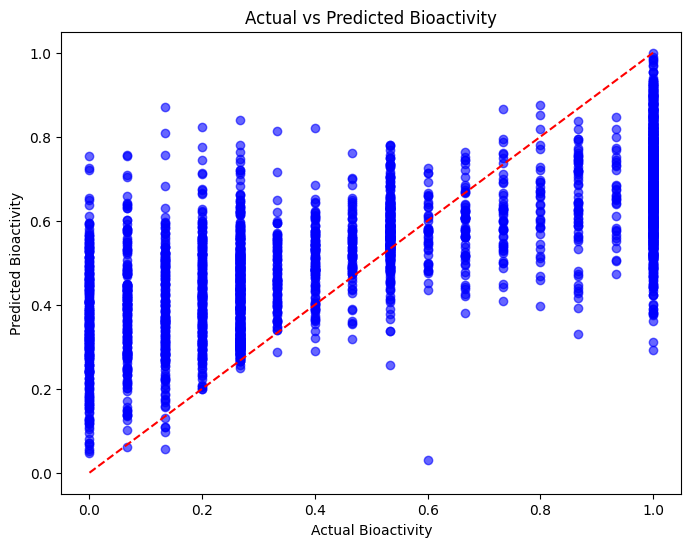

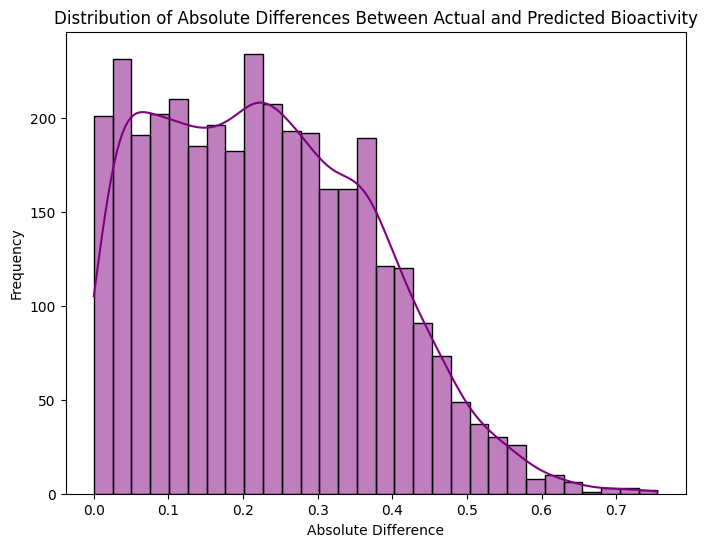

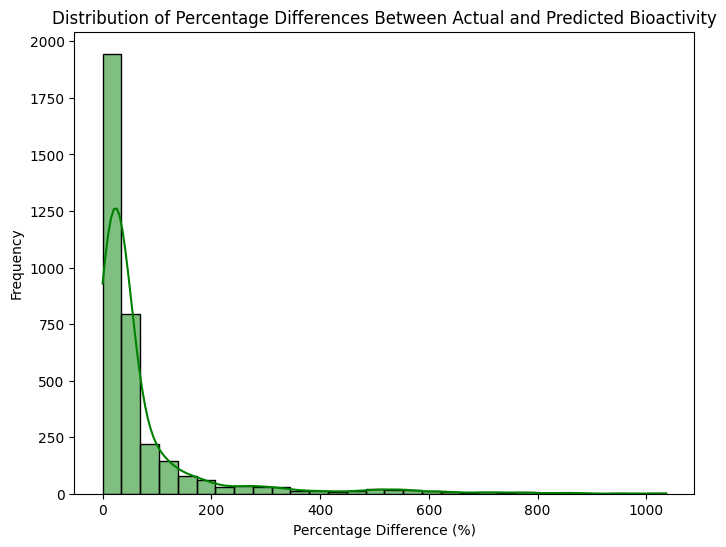

Model Accuracy (Predictions within 20% error): 32.84%
Root Mean Squared Error: 0.3446501888268561


In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error

import pickle
with open('xgboost_model_kinase0.pkl', 'rb') as f:
    model_protein0 = pickle.load(f)

df_filtered = df[df['Kinase'] == 0]

X_filtered_dmatrix = xgb.DMatrix(X_filtered)
predictions = model_protein0.predict(X_filtered_dmatrix)

differences = []  # store the differences between actual and predicted values
percentage_differences = []  # store percentage differences for each prediction

for i, smiles in enumerate(df_filtered['Smiles']):
    actual_bioactivity = df_filtered.iloc[i]['Bioactivities']
    predicted_bioactivity = predictions[i]

    difference = abs(actual_bioactivity - predicted_bioactivity)
    percentage_difference = (difference / actual_bioactivity) * 100 if actual_bioactivity != 0 else 0
    differences.append(difference)
    percentage_differences.append(percentage_difference)

# plot Actual vs Predicted Bioactivity
plt.figure(figsize=(8, 6))
plt.scatter(df_filtered['Bioactivities'], predictions, alpha=0.6, color='b')
plt.plot([df_filtered['Bioactivities'].min(), df_filtered['Bioactivities'].max()],
         [df_filtered['Bioactivities'].min(), df_filtered['Bioactivities'].max()], '--r')
plt.title('Actual vs Predicted Bioactivity')
plt.xlabel('Actual Bioactivity')
plt.ylabel('Predicted Bioactivity')
plt.show()

# plot Distribution of Absolute Differences
plt.figure(figsize=(8, 6))
sns.histplot(differences, bins=30, kde=True, color='purple')
plt.title('Distribution of Absolute Differences Between Actual and Predicted Bioactivity')
plt.xlabel('Absolute Difference')
plt.ylabel('Frequency')
plt.show()

# plot Distribution of Percentage Differences
plt.figure(figsize=(8, 6))
sns.histplot(percentage_differences, bins=30, kde=True, color='green')
plt.title('Distribution of Percentage Differences Between Actual and Predicted Bioactivity')
plt.xlabel('Percentage Difference (%)')
plt.ylabel('Frequency')
plt.show()

# calculate model accuracy with 20% error, but focus on RSME more than model accuracy of XGBoost (Deiscion Tree/Regression Model)
accurate_predictions = sum(1 for pd in percentage_differences if pd <= 20)
accuracy_percentage = (accurate_predictions / len(percentage_differences)) * 100

print(f"Model Accuracy (Predictions within 20% error): {accuracy_percentage:.2f}%")

# rsme
y_test_dmatrix = xgb.DMatrix(X_test)
rmse = np.sqrt(mean_squared_error(y_test, model_protein0.predict(y_test_dmatrix)))
print(f"Root Mean Squared Error: {rmse}")



**NEW** : Model for Predicting Bioactivities of Protein 1 Uses New Scaled Dataset

Filtered dataset shape: (25249, 8)
Training and Testing data shapes: (20199, 2048), (5050, 2048), (20199,), (5050,)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:723: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:01:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.27735
[1]	eval-rmse:0.27718
[2]	eval-rmse:0.27702
[3]	eval-rmse:0.27687
[4]	eval-rmse:0.27672
[5]	eval-rmse:0.27657
[6]	eval-rmse:0.27642
[7]	eval-rmse:0.27627
[8]	eval-rmse:0.27613
[9]	eval-rmse:0.27599
[10]	eval-rmse:0.27585
[11]	eval-rmse:0.27571
[12]	eval-rmse:0.27559
[13]	eval-rmse:0.27546
[14]	eval-rmse:0.27533
[15]	eval-rmse:0.27520
[16]	eval-rmse:0.27509
[17]	eval-rmse:0.27496
[18]	eval-rmse:0.27484
[19]	eval-rmse:0.27473
[20]	eval-rmse:0.27461
[21]	eval-rmse:0.27449
[22]	eval-rmse:0.27437
[23]	eval-rmse:0.27424
[24]	eval-rmse:0.27414
[25]	eval-rmse:0.27402
[26]	eval-rmse:0.27390
[27]	eval-rmse:0.27379
[28]	eval-rmse:0.27369
[29]	eval-rmse:0.27358
[30]	eval-rmse:0.27346
[31]	eval-rmse:0.27337
[32]	eval-rmse:0.27326
[33]	eval-rmse:0.27315
[34]	eval-rmse:0.27305
[35]	eval-rmse:0.27295
[36]	eval-rmse:0.27285
[37]	eval-rmse:0.27276
[38]	eval-rmse:0.27266
[39]	eval-rmse:0.27256
[40]	eval-rmse:0.27248
[41]	eval-rmse:0.27239
[42]	eval-rmse:0.27229
[43]	eval-rmse:0.2722

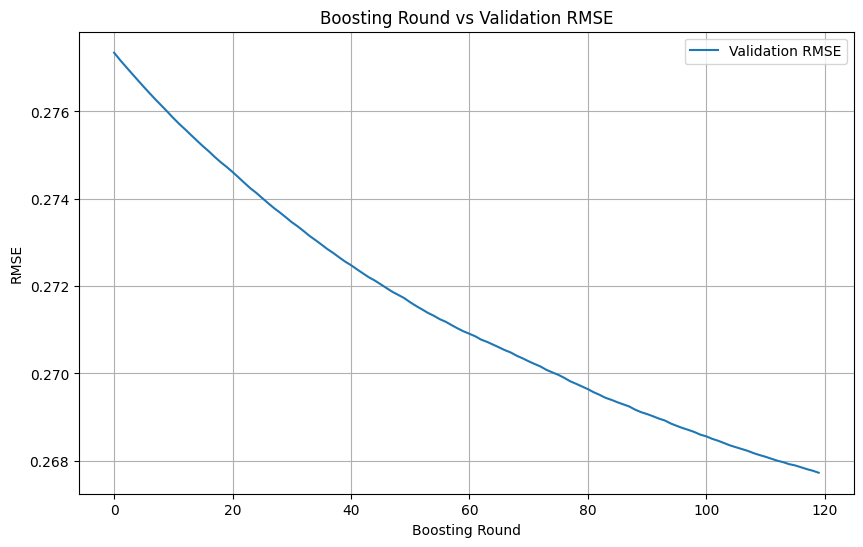

<Figure size 1000x600 with 0 Axes>

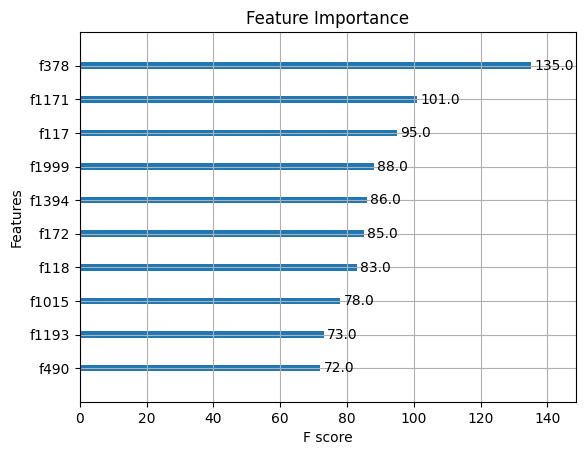

Root Mean Squared Error (RMSE): 0.26772664149776976


In [36]:
import torch
import xgboost as xgb
import rdkit
import pandas as pd
from sklearn.model_selection import train_test_split
from rdkit import Chem
from rdkit.Chem import rdMolDescriptors
import numpy as np
from sklearn.metrics import mean_squared_error
import pickle
import matplotlib.pyplot as plt

data_path = '/content/drive/My Drive/data/cleaned_dataset_minmax.csv'
df = pd.read_csv(data_path)
df.head()

# same as kinase 0 but filtering to just be kinase 1 molecules
df_filtered = df[df['Kinase'] == 1]

print(f"Filtered dataset shape: {df_filtered.shape}")
df_filtered.head()

def smiles_to_fingerprint(smiles, radius=2, nBits=2048):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        fingerprint = rdMolDescriptors.GetMorganFingerprintAsBitVect(mol, radius, nBits)
        return np.array(fingerprint)
    else:
        return np.zeros(nBits)

fingerprints = df_filtered['Smiles'].apply(smiles_to_fingerprint)

X_filtered = np.array(fingerprints.tolist())

y_filtered = df_filtered['Bioactivities']

X_train, X_test, y_train, y_test = train_test_split(X_filtered, y_filtered, test_size=0.2, random_state=42)

print(f"Training and Testing data shapes: {X_train.shape}, {X_test.shape}, {y_train.shape}, {y_test.shape}")

train_data = xgb.DMatrix(X_train, label=y_train)
test_data = xgb.DMatrix(X_test, label=y_test)

params = {
    'objective': 'reg:squarederror',  # Regression task
    'max_depth': 6,                   # Tree depth
    'eta': 0.01,  # Learning rate
    'lambda': 8,  # L2 regularization
    'alpha': 0.1,  # L1 regularization
    'silent': 1,
    'eval_metric': 'rmse',            # Root Mean Squared Error
}

num_round = 120
evals_result = {}
model_protein1 = xgb.train(params, train_data, num_round, [(test_data, 'eval')], evals_result=evals_result)

# saving model for later use
with open('xgboost_model_kinase1.pkl', 'wb') as f:
    pickle.dump(model_protein1, f)
    print("Model saved successfully!")

y_pred = model_protein1.predict(test_data)

# evaluate models preformance
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Root Mean Squared Error (RMSE): {rmse}')

print(evals_result)

plt.figure(figsize=(10, 6))

# plot rsme graph
if 'eval' in evals_result and 'rmse' in evals_result['eval']:
    plt.plot(evals_result['eval']['rmse'], label='Validation RMSE')
else:
    print("Expected RMSE key not found for eval in evals_result.")

if 'train' in evals_result and 'rmse' in evals_result['train']:
    plt.plot(evals_result['train']['rmse'], label='Training RMSE')
else:
    print("Expected RMSE key not found for train in evals_result.")

plt.xlabel('Boosting Round')
plt.ylabel('RMSE')
plt.title('Boosting Round vs Validation RMSE')
plt.legend()
plt.grid(True)
plt.show()

# feature importance graph
plt.figure(figsize=(10, 6))
xgb.plot_importance(model_protein1, importance_type='weight', max_num_features=10)
plt.title('Feature Importance')
plt.show()
print(f'Root Mean Squared Error (RMSE): {rmse}')


**NEW** : Testing model prediction for Protein 1

In [37]:
# testing model that it is running
new_smiles = ['CN(C)CCN1C(=O)c2ccccc2N(C)c2ccccc21.Cl', 'CC1(C)[C@H]2[C@H]3[C@@H](CC[C@]3(C)O)[C@](C)(O)CC[C@H]21']  # Add your own test SMILES here
new_fps = np.array([smiles_to_fingerprint(smiles) for smiles in new_smiles])
new_data = xgb.DMatrix(new_fps)

new_predictions = model_protein1.predict(new_data)
print(new_predictions)



[0.53216136 0.484229  ]


**NEW** : Model Testing and Accuracy Prediction of Protein1, Accuracy Low but RSME okay, RSME more important

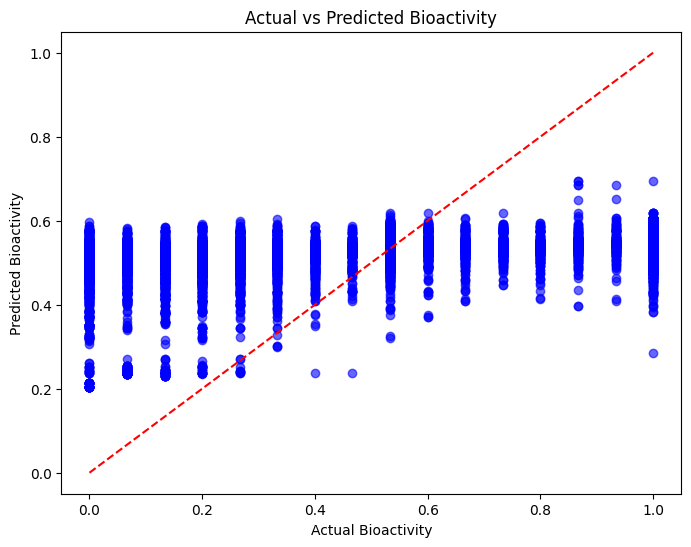

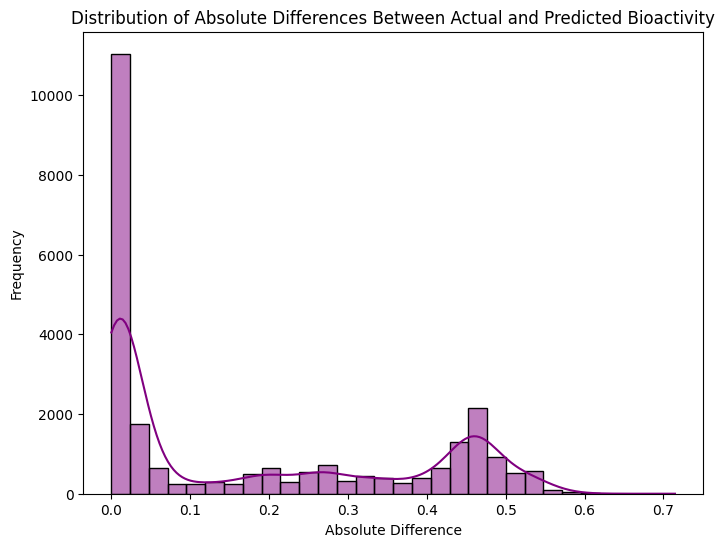

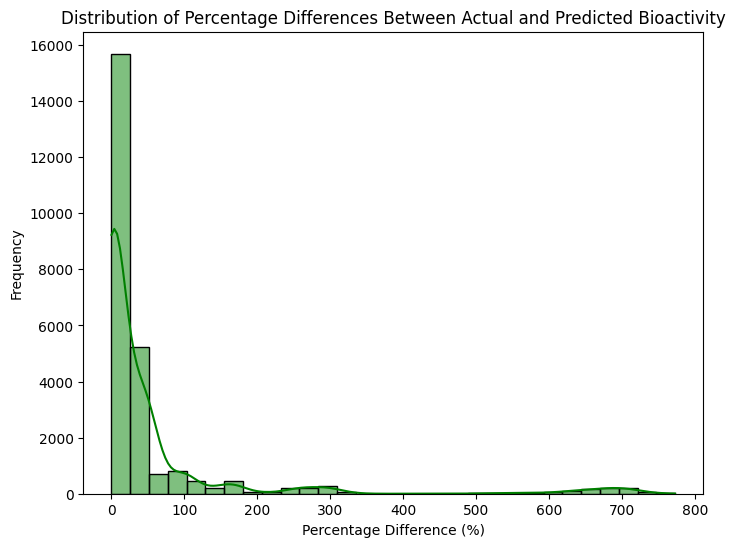

Model Accuracy (Predictions within 20% error): 60.84%
Root Mean Squared Error: 0.26772664149776976


In [38]:
# all same as kinase 0 model testing, just filtering to be kinase 1 molecules
with open('xgboost_model_kinase1.pkl', 'rb') as f:
    model_protein1 = pickle.load(f)

df_filtered_kinase1 = df[df['Kinase'] == 1]

# Get the predictions from the model for Kinase 1
X_filtered_kinase1 = df_filtered_kinase1['Smiles'].apply(smiles_to_fingerprint)
X_filtered_dmatrix_kinase1 = xgb.DMatrix(np.array(X_filtered_kinase1.tolist()))
predictions_kinase1 = model_protein1.predict(X_filtered_dmatrix_kinase1)

differences_kinase1 = []
percentage_differences_kinase1 = []

for i, smiles in enumerate(df_filtered_kinase1['Smiles']):
    actual_bioactivity = df_filtered_kinase1.iloc[i]['Bioactivities']
    predicted_bioactivity = predictions_kinase1[i]

    # Calculate the absolute difference and the percentage difference
    difference = abs(actual_bioactivity - predicted_bioactivity)
    percentage_difference = (difference / actual_bioactivity) * 100 if actual_bioactivity != 0 else 0
    differences_kinase1.append(difference)
    percentage_differences_kinase1.append(percentage_difference)

# Plot Actual vs Predicted Bioactivity for Kinase 1
plt.figure(figsize=(8, 6))
plt.scatter(df_filtered_kinase1['Bioactivities'], predictions_kinase1, alpha=0.6, color='b')
plt.plot([df_filtered_kinase1['Bioactivities'].min(), df_filtered_kinase1['Bioactivities'].max()],
         [df_filtered_kinase1['Bioactivities'].min(), df_filtered_kinase1['Bioactivities'].max()], '--r')
plt.title('Actual vs Predicted Bioactivity')
plt.xlabel('Actual Bioactivity')
plt.ylabel('Predicted Bioactivity')
plt.show()

# Plot Distribution of Absolute Differences for Kinase 1
plt.figure(figsize=(8, 6))
sns.histplot(differences_kinase1, bins=30, kde=True, color='purple')
plt.title('Distribution of Absolute Differences Between Actual and Predicted Bioactivity')
plt.xlabel('Absolute Difference')
plt.ylabel('Frequency')
plt.show()

# Plot Distribution of Percentage Differences for Kinase 1
plt.figure(figsize=(8, 6))
sns.histplot(percentage_differences_kinase1, bins=30, kde=True, color='green')
plt.title('Distribution of Percentage Differences Between Actual and Predicted Bioactivity')
plt.xlabel('Percentage Difference (%)')
plt.ylabel('Frequency')
plt.show()

# Calculate model accuracy for Kinase 1 (Percentage of samples with less than 20% error)
accurate_predictions_kinase1 = sum(1 for pd in percentage_differences_kinase1 if pd <= 20)
accuracy_percentage_kinase1 = (accurate_predictions_kinase1 / len(percentage_differences_kinase1)) * 100

print(f"Model Accuracy (Predictions within 20% error): {accuracy_percentage_kinase1:.2f}%")

# rsme
y_test_dmatrix_kinase1 = xgb.DMatrix(X_test)
rmse_kinase1 = np.sqrt(mean_squared_error(y_test, model_protein1.predict(y_test_dmatrix_kinase1)))
print(f"Root Mean Squared Error: {rmse_kinase1}")

**NEW**: Bioactivity Cross-Prediction and Save To Combined Dataset with Cross-Prediction Scores as "Bioactivity 2"

In [41]:
import torch
import xgboost as xgb
import rdkit
import pandas as pd
from sklearn.model_selection import train_test_split
from rdkit import Chem
from rdkit.Chem import rdMolDescriptors
import numpy as np
from sklearn.metrics import mean_squared_error
import pickle
import matplotlib.pyplot as plt

# Load the saved model for Kinase 1 (for predicting Kinase 1 bioactivity on Kinase 0 molecules)
with open('xgboost_model_kinase1.pkl', 'rb') as f:
    model_protein1 = pickle.load(f)

# Load the saved model for Kinase 0 (for predicting Kinase 0 bioactivity on Kinase 1 molecules)
with open('xgboost_model_kinase0.pkl', 'rb') as f:
    model_protein0 = pickle.load(f)

data_path = '/content/drive/My Drive/data/cleaned_dataset_minmax.csv'
df = pd.read_csv(data_path)
df.head()

df_kinase0 = df[df['Kinase'] == 0]
df_kinase1 = df[df['Kinase'] == 1]

def smiles_to_fingerprint(smiles, radius=2, nBits=2048):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        fingerprint = rdMolDescriptors.GetMorganFingerprintAsBitVect(mol, radius, nBits)
        return np.array(fingerprint)
    else:
        return np.zeros(nBits)

# Create the feature matrix X and target vector y for Kinase 0 molecules
X_kinase0 = np.array(df_kinase0['Smiles'].apply(smiles_to_fingerprint).tolist())

# Create the feature matrix X and target vector y for Kinase 1 molecules
X_kinase1 = np.array(df_kinase1['Smiles'].apply(smiles_to_fingerprint).tolist())

# Predict Bioactivity for Kinase 0 molecules (Kinase 1 model)
X_kinase0_dmatrix = xgb.DMatrix(X_kinase0)
bioactivity_pred_kinase0 = model_protein1.predict(X_kinase0_dmatrix)

# Predict Bioactivity for Kinase 1 molecules (Kinase 0 model)
X_kinase1_dmatrix = xgb.DMatrix(X_kinase1)
bioactivity_pred_kinase1 = model_protein0.predict(X_kinase1_dmatrix)

# Add the predicted bioactivities as new columns to the original dataframe
df_kinase0['Bioactivity 2nd'] = bioactivity_pred_kinase0
df_kinase1['Bioactivity 2nd'] = bioactivity_pred_kinase1

# Combine both Kinase 0 and Kinase 1 molecules back into one dataframe
df_combined = pd.concat([df_kinase0, df_kinase1], axis=0)

df_combined = df_combined.sort_index()

print(df_combined[['Smiles', 'Bioactivities', 'Bioactivity 2nd']].head())

# save this dataframe as csv
df_combined.to_csv('drive/My Drive/data/both_bioactivity_predictions.csv', index=False)

<ipython-input-41-ba2e3de16754>:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_kinase0['Bioactivity 2nd'] = bioactivity_pred_kinase0
<ipython-input-41-ba2e3de16754>:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_kinase1['Bioactivity 2nd'] = bioactivity_pred_kinase1


                                              Smiles  Bioactivities  \
0                     O=C1NC(=O)C2(c3ccc(Cl)cc3)CC12       0.533333   
1  CCCNCC(O)COc1ccc2c(=O)cc(-c3ccccc3)oc2c1.O=C(O...       0.533333   
2             Cc1oc2c(C)c3oc(=O)cc(C)c3cc2c1COCCN.Cl       0.533333   
3                  C[C@@H](/N=C(\S)Nc1nccs1)C1CCCCC1       0.333333   
4                          O=c1[nH]c2cccnc2c2ccccc12       0.133333   

   Bioactivity 2nd  
0         0.522871  
1         0.519286  
2         0.536895  
3         0.536913  
4         0.548460  


**NEW** : Combined Score Calculation Using Weights


In [51]:
data_path = 'drive/My Drive/data/both_bioactivity_predictions.csv'
df = pd.read_csv(data_path)
df.head()

# weights for bioactivity
w_bioactivity = 0.5
w_bioactivity2 = 0.5

# combining the scores using the weights
df['Combined_Score'] = (w_bioactivity * df['Bioactivities']) + (w_bioactivity2 * df['Bioactivity 2nd'])

# save the entire dataset with the combined score to a CSV file
df.to_csv('drive/My Drive/data/combined_bioactivities.csv', index=False)

print(df[['Smiles', 'Bioactivities', 'Bioactivity 2nd', 'Combined_Score']])

#Printing out the top bioactivitiy score molecules pretty close to 1 values
print("\nTOP 10 DUAL BIOACTIVITY MOLECULES")
top_molecules = df.sort_values(by='Combined_Score', ascending=False).head(10)
print(top_molecules[['Smiles', 'Bioactivities', 'Bioactivity 2nd', 'Combined_Score']])



                                                  Smiles  Bioactivities  \
0                         O=C1NC(=O)C2(c3ccc(Cl)cc3)CC12       0.533333   
1      CCCNCC(O)COc1ccc2c(=O)cc(-c3ccccc3)oc2c1.O=C(O...       0.533333   
2                 Cc1oc2c(C)c3oc(=O)cc(C)c3cc2c1COCCN.Cl       0.533333   
3                      C[C@@H](/N=C(\S)Nc1nccs1)C1CCCCC1       0.333333   
4                              O=c1[nH]c2cccnc2c2ccccc12       0.133333   
...                                                  ...            ...   
28761          CC(C)Cc1ccc([C@@H](C)C(=O)NS(C)(=O)=O)cc1       1.000000   
28762  CCC[C@H](C)OC(=O)[C@H](C)NP(=O)(OC[C@H]1OC[C@@...       0.533333   
28763                     CC12CC3CC(C)(C1)CC(N)(C3)C2.Cl       1.000000   
28764  CC[C@H]1[C@@H]2C[C@H]3[C@@H]4N(C)c5ccccc5[C@]4...       1.000000   
28765  Cn1c(-c2ccccn2)c(C2CCCC2)c2ccc(C(=O)NC3(C(=O)N...       1.000000   

       Bioactivity 2nd  Combined_Score  
0             0.522871        0.528102  
1             0.5

Viewing Distribution of Combined Scores to Determine Threshold To Use for Filtering


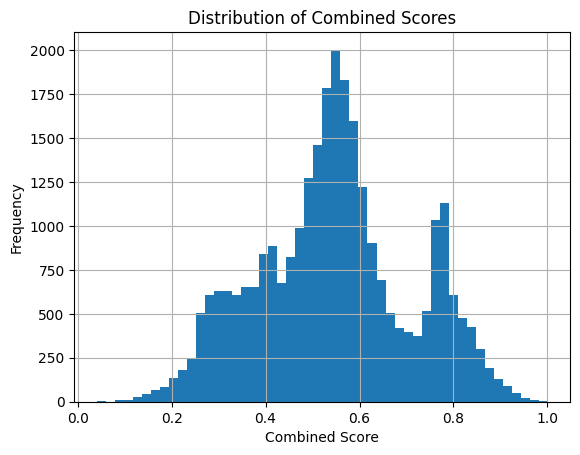

In [60]:
data_path = 'drive/My Drive/data/combined_bioactivities.csv'
df = pd.read_csv(data_path)
df.head()
df['Combined_Score'].hist(bins=50)
plt.title('Distribution of Combined Scores')
plt.xlabel('Combined Score')
plt.ylabel('Frequency')
plt.show()

Filters at Threshold 0.45 as 0.5 was highest frequency, and is also a midway score to getting close to that 1


In [65]:
data_path = 'drive/My Drive/data/combined_bioactivities.csv'
df = pd.read_csv(data_path)
df.head()
threshold = 0.45
filtered_molecules = df[df['Combined_Score'] >= threshold]

print(f"Number of molecules with combined score >= {threshold}: {len(filtered_molecules)}")
filtered_molecules.head()

filtered_molecules.to_csv('drive/My Drive/data/filtered_molecules.csv', index=False)

Number of molecules with combined score >= 0.45: 21032


**NOTE**: More Additions Below After Model and Training
, During Test-Data Calls


MODEL

In [9]:
class MolecularVAE(nn.Module):
    def __init__(self, charset_length=33, input_len=120, dropout_rate=0.1): #
        super(MolecularVAE, self).__init__()

        self.input_len = input_len
        self.dropout_rate = dropout_rate

        self.conv_1 = nn.Conv1d(input_len, 9, kernel_size=9)
        self.conv_2 = nn.Conv1d(9, 9, kernel_size=9)
        self.conv_3 = nn.Conv1d(9, 10, kernel_size=11)

        # Calculate the size after convolution operations
        L = charset_length
        L = (L - 9 + 1)  # after conv_1
        L = (L - 9 + 1)  # after conv_2
        L = (L - 11 + 1)  # after conv_3

        self.linear_0 = nn.Linear(10*L, 435)
        self.linear_1 = nn.Linear(435, 292)
        self.linear_2 = nn.Linear(435, 292)

        self.linear_3 = nn.Linear(292, 292)
        self.gru = nn.GRU(292, 501, 3, batch_first=True)
        self.linear_4 = nn.Linear(501, charset_length)

        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=2)

         # Dropout layer
        self.dropout = nn.Dropout(p=self.dropout_rate)

    def encode(self, x):
        x = self.relu(self.conv_1(x))
        x = self.relu(self.conv_2(x))
        x = self.relu(self.conv_3(x))
        x = x.view(x.size(0), -1)
        x = F.selu(self.linear_0(x))
        x = self.dropout(x)  # Apply dropout after linear_0
        return self.linear_1(x), self.linear_2(x)

    def sampling(self, z_mean, z_logvar):
        epsilon = 1e-2 * torch.randn_like(z_logvar)
        return torch.exp(0.5 * z_logvar) * epsilon + z_mean

    def decode(self, z):
        z = F.selu(self.linear_3(z))
        z = self.dropout(z)
        z = z.view(z.size(0), 1, z.size(-1)).repeat(1, self.input_len, 1)
        output, hn = self.gru(z)
        out_reshape = output.contiguous().view(-1, output.size(-1))
        y0 = F.softmax(self.linear_4(out_reshape), dim=1)
        y = y0.contiguous().view(output.size(0), -1, y0.size(-1))
        return y

    def forward(self, x):
        z_mean, z_logvar = self.encode(x)
        z = self.sampling(z_mean, z_logvar)
        return self.decode(z), z_mean, z_logvar

LOSS FUNCTION

In [10]:
def vae_loss(x_decoded_mean, x, z_mean, z_logvar):
    xent_loss = F.binary_cross_entropy(x_decoded_mean, x, size_average=False)
    kl_loss = -0.5 * torch.sum(1 + z_logvar - z_mean.pow(2) - z_logvar.exp())
    return xent_loss + kl_loss

data_train, data_test, charset = load_dataset(data_file_to_load_from)
data_train = torch.utils.data.TensorDataset(torch.from_numpy(data_train))
train_loader = torch.utils.data.DataLoader(data_train, batch_size=256, shuffle=True)

print(f'Charset length: {charset_len}', type(charset_len))
print(f'Input length: {input_len}', type(input_len))
model = MolecularVAE(charset_length=charset_len, input_len=input_len, dropout_rate=0.1).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=100, verbose=True)

Charset length: 41 <class 'int'>
Input length: 42 <class 'int'>


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


TRAINING LOOP

In [11]:
# Create checkpoints directory if it doesn't exist
if not os.path.exists('drive/My Drive/data/checkpoints'):
    os.makedirs('drive/My Drive/data/checkpoints')

# List to store the loss for each epoch
losses = []

# Modify your training loop to track the loss per epoch
def train(epoch):
    model.train()
    train_loss = 0

    for batch_idx, data in enumerate(train_loader):
        data = data[0].to(device)
        optimizer.zero_grad()
        output, mean, logvar = model(data)

        if batch_idx == 0 and epoch % checkpoint_frequency == 0:
            inp = data.cpu().numpy()
            outp = output.cpu().detach().numpy()
            lab = data.cpu().numpy()

            #decoded_smiles = decode_smiles_from_indexes(map(from_one_hot_array, inp[0]), charset)
            #label = smiles_to_label.get(decoded_smiles, None)  # Get label from dictionary

            print("Epoch:", epoch)
            print("Input:")
            print(decode_smiles_from_indexes(map(from_one_hot_array, inp[0]), charset))
            print("Label:")
            print(decode_smiles_from_indexes(map(from_one_hot_array, lab[0]), charset))
            sampled = outp[0].reshape(1, input_len, len(charset)).argmax(axis=2)[0]
            print("Output:")
            print(decode_smiles_from_indexes(sampled, charset))
            # Save checkpoint
            torch.save(model.state_dict(), f'drive/My Drive/data/checkpoints/{epoch}_checkpoint_{data_signature}.pt')

        loss = vae_loss(output, data, mean, logvar)
        loss.backward()
        train_loss += loss.item()  # Accumulate the loss (use .item() for scalar value)
        optimizer.step()

    # Print statement remains unchanged
    print('train', train_loss / len(train_loader.dataset))

    # Append the loss for this epoch to the list
    losses.append(train_loss / len(train_loader.dataset))

    return train_loss / len(train_loader.dataset)  # Return is unchanged

In [12]:
import matplotlib.pyplot as plt

if LOAD_FROM_CHECKPOINT:
    model.load_state_dict(torch.load(checkpoint_path, map_location=torch.device('cpu')))
else:
    for epoch in range(1, epochs + 1):
        train_loss = train(epoch)
        scheduler.step(train_loss)

  # After training, plot the loss curve
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, epochs + 1), losses, label='Training Loss', color='b')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Get highest numberd checkpoint with this data signature from the checkpoints directory
    checkpoints = os.listdir('drive/My Drive/data/checkpoints')
    checkpoints = [c for c in checkpoints if data_signature in c]
    checkpoints = [c.split('_')[0] for c in checkpoints]
    last_checkpoint = max([int(c) for c in checkpoints])

    model.load_state_dict(torch.load(f'drive/My Drive/data/checkpoints/{last_checkpoint}_checkpoint_{data_signature}.pt', map_location=torch.device('cpu')))


<ipython-input-12-30345ee74e33>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path, map_location=torch.device('cpu')))


Imports for Property Prediction

In [18]:
from rdkit import Chem, rdBase
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors
from rdkit.Chem import Draw
from IPython.display import display
import rdkit.Chem.QED as QED
from rdkit.Chem import RDConfig
import os
import sys
import matplotlib.pyplot as plt
sys.path.append(os.path.join(RDConfig.RDContribDir, 'SA_Score'))
import sascorer
from rdkit.Chem import Lipinski

Blood Brain Barrier Permeability Function

In [19]:
def predicting_bbb(logp, mw, psa, hbd, hba):
  predicted_score = 0
  if logp <= 3 and logp >= 1:
    if mw <= 450:
      if psa <= 95:
        if hbd <= 5:
          if hba <= 10:
            predicted_score = 1
  else:
    return predicted_score
  return predicted_score

CALCULATE METRICS AND SHOW RANDOMIZED SAMPLED MOLECULES FROM LATENT SPACE

In [20]:
def calculate_mol_metrics(smiles):
    #predict metrics and molweight
    mols = [Chem.MolFromSmiles(s) for s in smiles]
    # Filter out invalid molecules (None values)
    valid_mols = [m for m in mols if m is not None]
    valid = [1 if m else 0 for m in mols]
    print(f'Num valid: {sum(valid)}')
    frac_valid = sum(valid) / len(valid)
    mol_wt = [Descriptors.MolWt(m) for m in mols if m]
    avg_mol_wt = sum(mol_wt) / len(mol_wt)

    #predict logP
    logP = [Descriptors.MolLogP(m) for m in mols if m]
    avg_logP = sum(logP) / len(logP)

    #predict QED
    qed_score = [QED.qed(m) for m in mols if m]
    avg_qed = sum(qed_score) / len(qed_score)

    #predict synthetic accesibility score
    sas = [sascorer.calculateScore(m) for m in mols if m]
    avg_sas = sum(sas) / len(sas)

    #predict labute asa score
    labute_asa = [Descriptors.LabuteASA(m) for m in mols if m]
    avg_labute_asa = sum(labute_asa) / len(labute_asa)

    count_of_bbb_score = 0
    for m in valid_mols:
      lipophili = Descriptors.MolLogP(m)
      mw = Descriptors.MolWt(m)
      psa = Descriptors.TPSA(m)
      hba = Lipinski.NumHAcceptors(m)
      hbd = Lipinski.NumHDonors(m)
      bbb_score = predicting_bbb(lipophili, mw, psa, hbd, hba)
      if bbb_score == 1:
        count_of_bbb_score += 1
    avg_bbb_score = count_of_bbb_score

    #predict lipinski rule of 5
    lipinski_count = 0

    for m in valid_mols:
        if m:  # Check if molecule is valid
            # Extract the metrics for each molecule
            MW = Descriptors.MolWt(m)
            HBA = Descriptors.NOCount(m)
            HBD = Descriptors.NHOHCount(m)
            LogP = Descriptors.MolLogP(m)

            # Check if the molecule passes Lipinski's Rule of 5 conditions
            conditions = [
                MW <= 500,
                HBA <= 10,
                HBD <= 5,
                LogP <= 5
            ]
            # Count the number of conditions the molecule passes
            if conditions.count(True) >= 3:
                lipinski_count += 1

    return frac_valid, avg_mol_wt, avg_logP, avg_qed, avg_sas, avg_labute_asa, lipinski_count, avg_bbb_score

**NEW** : Combined Score Prediction for GENERATED Molecules, Threshold is stricter (0.5), Added Generated Molecules to dataset for model to also learn from what it has self-generated


In [85]:
# Function to convert SMILES to Morgan Fingerprints (same as before)
def smiles_to_fingerprint(smiles, radius=2, nBits=2048):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        fingerprint = rdMolDescriptors.GetMorganFingerprintAsBitVect(mol, radius, nBits)
        return np.array(fingerprint)
    else:
        return np.zeros(nBits)

import pandas as pd
import numpy as np
import xgboost as xgb
from rdkit import Chem
from rdkit.Chem import Draw
import pickle

def add_generated_molecules_to_filtered(filtered_df, decoded_smiles, threshold=0.5):
    with open('xgboost_model_kinase0.pkl', 'rb') as f:
        model_protein0 = pickle.load(f)

    # converting the smiles parameter into the morgan fingerprints for the bioactivity prediction
    fingerprints_valid = [smiles_to_fingerprint(smiles) for smiles in decoded_smiles]
    X_valid = np.array(fingerprints_valid)
    X_valid_dmatrix = xgb.DMatrix(X_valid)

    # prediction of kinase 0 bioactivity
    predictions_valid0 = model_protein0.predict(X_valid_dmatrix)

    with open('xgboost_model_kinase1.pkl', 'rb') as f:
        model_protein1 = pickle.load(f)

    # predicition of kinase 1 bioactivity
    predictions_valid1 = model_protein1.predict(X_valid_dmatrix)

    # weighted sum for combined prediction using same weight values as before
    combined_predictions = 0.5 * predictions_valid0 + 0.5 * predictions_valid1

    # Filter the generated molecules based on the combined bioactivity score and the threshold
    valid_generated_molecules = [
        smiles for smiles, score in zip(decoded_smiles, combined_predictions) if score >= threshold
    ]

    # Print out how many valid molecules are above the threshold
    print(f"\nNumber of valid generated molecules with combined bioactivity score >= {threshold}: {len(valid_generated_molecules)}")

    # Create a DataFrame for the valid generated molecules with only Smiles and Combined_Score
    generated_df = pd.DataFrame({
        'Smiles': valid_generated_molecules,
        'Combined_Score': combined_predictions[:len(valid_generated_molecules)]  # Only the valid ones
    })

    # Add these valid generated molecules to the filtered dataset
    updated_filtered_df = pd.concat([filtered_df, generated_df], ignore_index=True)

    # Save the updated dataset to a new CSV file
    output_path = 'drive/My Drive/data/updated_filtered_with_generated.csv'
    updated_filtered_df.to_csv(output_path, index=False)

    print(f"\nUpdated dataset with generated molecules saved to: {output_path}")

    # printing top 10 molecules
    top_molecules = updated_filtered_df.sort_values(by='Combined_Score', ascending=False).head(10)
    print("\nTOP 10 MOLECULES BY COMBINED BIOACTIVITY SCORE")
    print(top_molecules[['Smiles', 'Combined_Score']])

    return updated_filtered_df



**UPDATE**: Updated Test_Data function to produce average of bioactivity scores of generated molecules, 0.5 was around the avg, therefore used for the threshold


**UPDATE**: Creates final dataset to use for training, provides data on combined scores and the SMILES but not really anything else as the SMILES are all that are needed for the VAE, hope is based off the SMILES that the model will end up creating better bioactivity scoring molecules as they will have similar structures to these ones


In [86]:
def test_data(data_test):
    # Use to predict from data_test
    if type(data_test) == np.ndarray:
        data_test = torch.from_numpy(data_test)
    elif type(data_test) == h5py.Dataset:
        data_test = torch.from_numpy(np.array(data_test))
    elif type(data_test) == torch.Tensor:
        data_test = torch.from_numpy(data_test.numpy()).float()
    else:
        data_test = data_test.float()

    data_test = data_test.to(device)
    output, _, _ = model(data_test)

    # Decode the output
    out = output.cpu().detach().numpy()
    out = out.reshape(out.shape[0], input_len, charset_len).argmax(axis=2)
    decoded = []
    for i in range(out.shape[0]):
        decoded.append(decode_smiles_from_indexes(map(int, out[i]), charset))

    # print the first 10 decoded SMILES and the test data
    for i in range(10):
        print(decoded[i])
        print(decode_smiles_from_indexes(map(from_one_hot_array, data_test[i].cpu().numpy()), charset))
        print()

    # calculate performance metrics
    rdBase.DisableLog('rdApp.*')

    frac_valid, avg_mol_wt, avg_logP, avg_qed, avg_sas, avg_labute_asa, lipinski_count, avg_bbb_score = calculate_mol_metrics(decoded)
    print(f'Fraction of valid molecules: {frac_valid}')
    print(f'Average molecular weight: {avg_mol_wt}')
    print(f'Average logP score: {avg_logP}')
    print(f'Average QED score: {avg_qed}')
    print(f'Average Synthetic Accessibility Score: {avg_sas}')
    print(f'Average Labute ASA score: {avg_labute_asa}')
    print(f'Total Lipinski Rule of 5 Passings: {lipinski_count}')
    print(f'# of BBB-P Passing: {avg_bbb_score}')

    # Draw the first 10 valid molecules
    valid_mols = [Chem.MolFromSmiles(s) for s in decoded if Chem.MolFromSmiles(s)]
    print([d for d in decoded if Chem.MolFromSmiles(d)])
    dr_mol = Draw.MolsToGridImage(valid_mols, molsPerRow=5, subImgSize=(200, 200))
    display(dr_mol)

    import pickle
    with open('xgboost_model_kinase0.pkl', 'rb') as f:
       model_protein0 = pickle.load(f)

    fingerprints_valid = [smiles_to_fingerprint(smiles) for smiles in decoded]

    X_valid = np.array(fingerprints_valid)

    X_valid_dmatrix = xgb.DMatrix(X_valid)
    # predicting smiles kinase 0 bioactivity
    predictions_valid = model_protein0.predict(X_valid_dmatrix)

    # Calculate the average bioactivity score
    avg_bioactivity = np.mean(predictions_valid)
    print(f"\nAverage Kinase 0 (CDK5) Bioactivity Score for Valid Molecules: {avg_bioactivity}")

    import pickle
    with open('xgboost_model_kinase1.pkl', 'rb') as f:
        model_protein1 = pickle.load(f)

    fingerprints_valid = [smiles_to_fingerprint(smiles) for smiles in decoded]
    X_valid = np.array(fingerprints_valid)

    X_valid_dmatrix = xgb.DMatrix(X_valid)

    # bioactivity prediction for kinase 1
    predictions_valid = model_protein1.predict(X_valid_dmatrix)

    # calculate avg bioactivity score
    avg_bioactivity = np.mean(predictions_valid)
    print(f"\nAverage Kinase 1 (BACE1) Bioactivity Score for Valid Molecules: {avg_bioactivity}")

    # adding generated smiles to filtered dataset
    filtered_data_path = 'drive/My Drive/data/filtered_molecules.csv'
    filtered_df = pd.read_csv(filtered_data_path)
    updated_filtered_molecules_df = add_generated_molecules_to_filtered(filtered_df, decoded)
    print(updated_filtered_molecules_df.head())


CN(C)ccccccCc2c(=C22c2222c22ccC))c2))c1C
CN(C)c1ncnc2c1ncn2CCn1cnc2ncnc(N(C)C)c21

CCC1CCCCCC22c2cCCCCCCCCC2
CC1OC2(CS1)CN1CCC2CC1.Cl.O

CCOC(O)[C1]C(CCCCC)CC(=)CCC(C)=C
CCOC(=O)CC/N=C(\N)N=C(N)N.Cl.Cl

C[CCN(CNCCCCCCc2ccccccccc22CCC3
CN1CC=C(C=Cc2c[nH]c3ccccc23)CC1

CCCCCCCC[CCCC@@H](@)[C@@H](HH]C@H]](O)
CCCCCCCCCCCCC[C@@H](O)C[C@@H](O)[C@H](C)N

COc1ccc2N(=C)cccccc3Fccc3)c22cc1
COc1ccc2nc(NC(=O)Nc3ccccc3)sc2c1

C1CCC2CCCC1(CCC(CCCCCC1)O2
C1CCC2(CC1)COC1(CCCCC1)OC2

O=C(CN1CCN(((=O)c2ccco2)CCC)Nc1ccccc1Br
O=C(CN1CCN(C(=O)c2ccco2)CC1)Nc1ccccc1Br

O=C(NC(=O)c2cc(CC)CCCCCc3c3ccc1
O=C(/C=C\Nc1ccccn1)c1ccc(Cl)cc1

Cl.=/C(O)C(=O)c1ccc(l)ccc1
CN(C)C(=O)CCNc1ccc(Br)cc1

Num valid: 36
Fraction of valid molecules: 0.1111111111111111
Average molecular weight: 229.57052777777778
Average logP score: 2.088026111111112
Average QED score: 0.5331448084967393
Average Synthetic Accessibility Score: 2.562547698414374
Average Labute ASA score: 93.49690145092214
Total Lipinski Rule of 5 Passings: 36
# of B

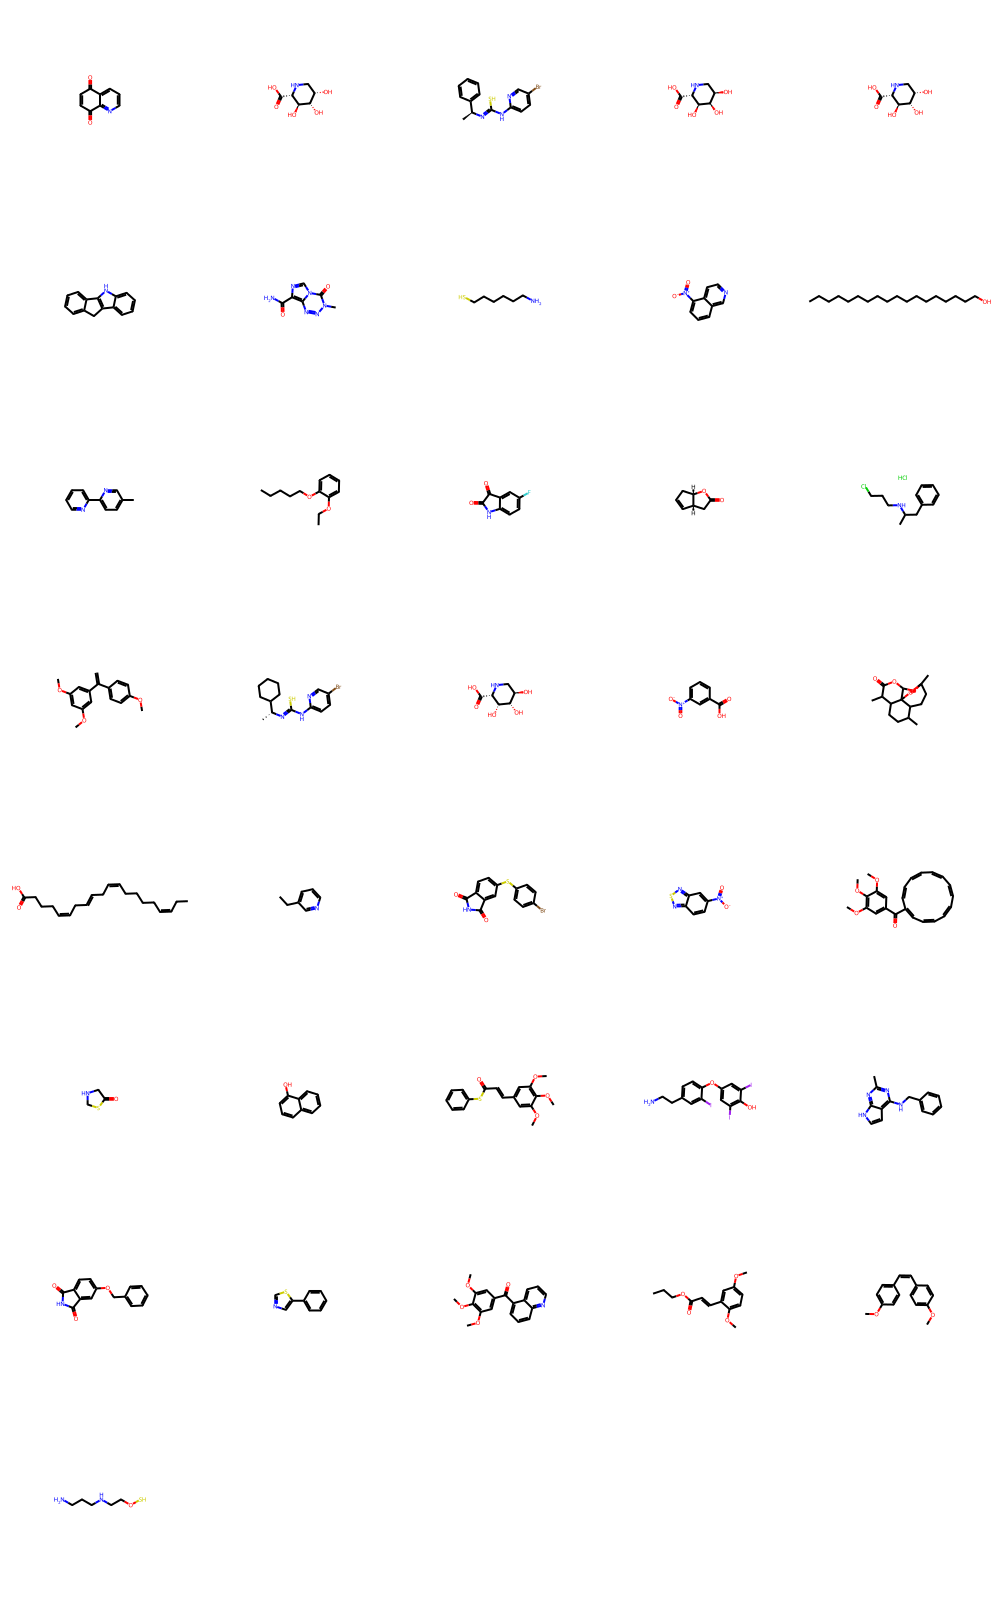


Average Kinase 0 (CDK5) Bioactivity Score for Valid Molecules: 0.5522051453590393

Average Kinase 1 (BACE1) Bioactivity Score for Valid Molecules: 0.501931369304657

Number of valid generated molecules with combined bioactivity score >= 0.5: 308

Updated dataset with generated molecules saved to: drive/My Drive/data/updated_filtered_with_generated.csv

TOP 10 MOLECULES BY COMBINED BIOACTIVITY SCORE
                                                  Smiles  Combined_Score
18849  Cc1c[nH]c(=O)n(CCCN2CCN(c3ccc(F)cc3OCC(F)(F)F)...        1.000916
20018  COC(=O)N[C@H](C(=O)N1CCC[C@H]1c1nc2cc([C@H]3CC...        0.999555
19304  CC1=C(C(=O)O)N2C(=O)[C@@H](NC(=O)[C@H](N)c3ccc...        0.988490
20810  Cc1cc2c(C(N)=O)cccc2n1-c1nc2c(c(NCc3ccccc3)n1)...        0.988423
18432  CO[C@@]12[C@H](COC(N)=O)C3=C(C(=O)C(C)=C(N)C3=...        0.982612
10142  O=c1c(-c2c(O)cc(O)c3c(=O)cc(-c4ccc(O)cc4)oc23)...        0.981448
11464     CN1CCN(c2c(F)cc3c(=O)c(C(=O)O)cn4c3c2OCN4C)CC1        0.981160
2525         

In [88]:
if RUN_ON_TEST_DATA:
    test_data(data_test)

PLOTTING PROPERTIES (GRAPH OF ALL AND INDIVIDUAL ONES)

Num valid: 35
Fraction of valid molecules: 0.10802469135802469
Average molecular weight: 231.9803428571428
Average logP score: 2.24101942857143
Average QED score: 0.5556016098956749
Average Synthetic Accessibility Score: 2.472129360042487
Average Labute ASA score: 95.52991733592853
Total Lipinski Rule of 5 Passings: 35
# of BBB-P Passing: 16


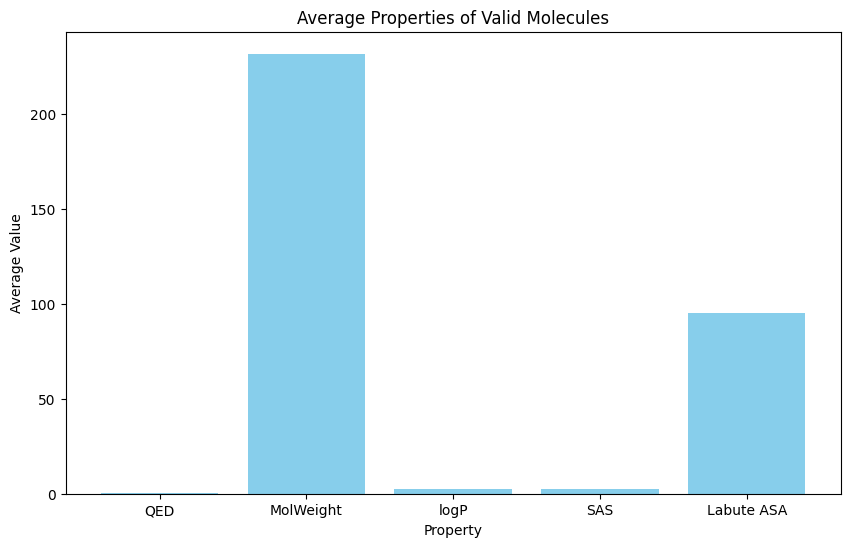

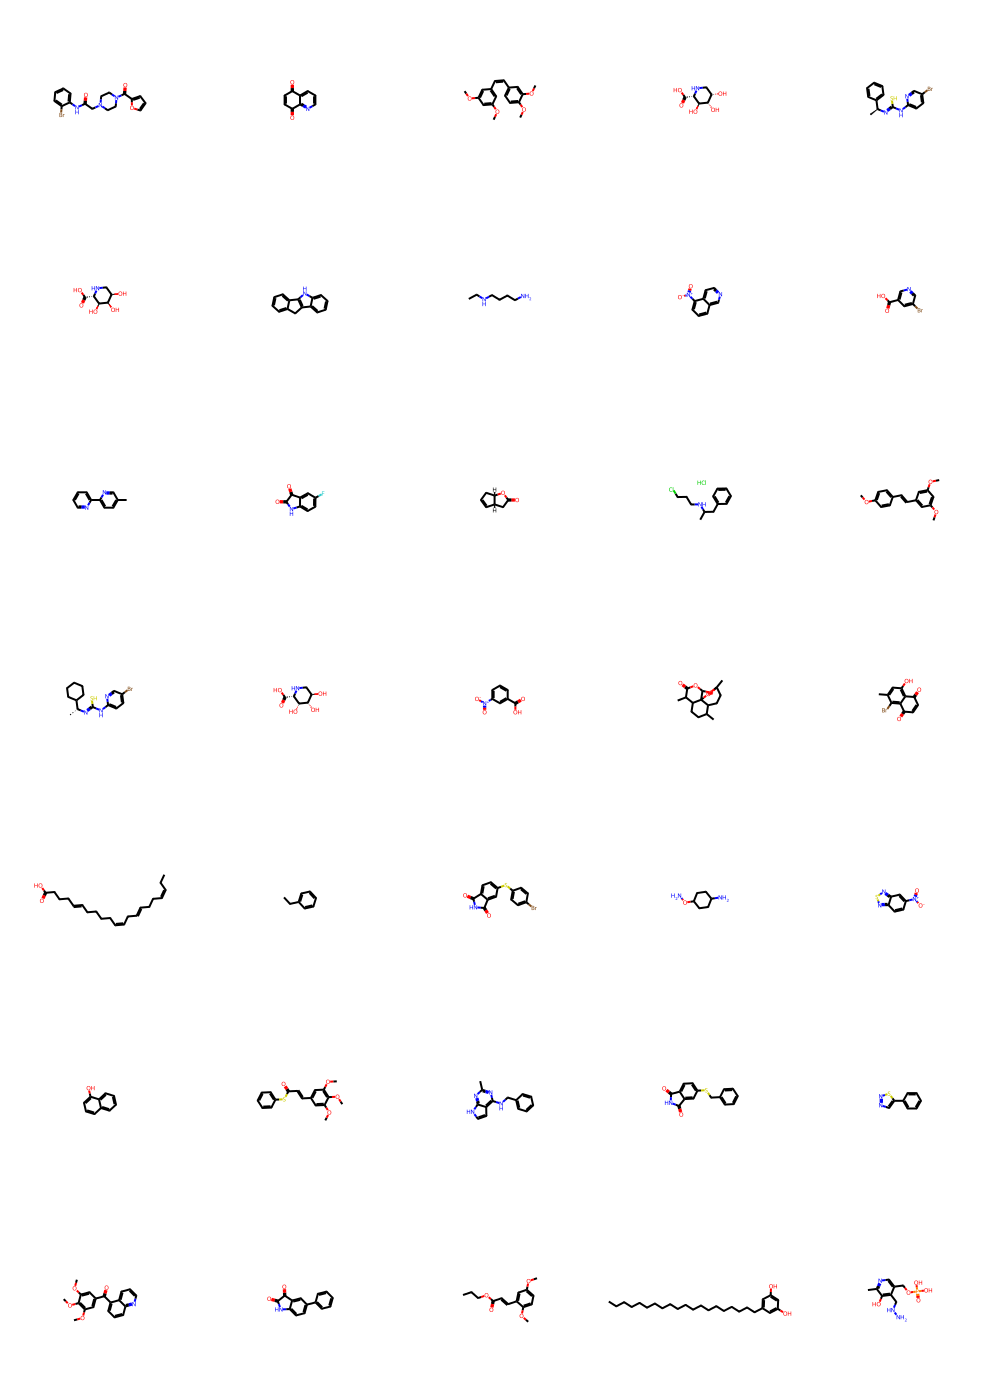

In [ ]:
def test_data(data_test):
    # Use to predict from data_test
    if type(data_test) == np.ndarray:
        data_test = torch.from_numpy(data_test)
    elif type(data_test) == h5py.Dataset:
        data_test = torch.from_numpy(np.array(data_test))
    elif type(data_test) == torch.Tensor:
        data_test = torch.from_numpy(data_test.numpy()).float()
    else:
        data_test = data_test.float()

    data_test = data_test.to(device)
    output, _, _ = model(data_test)

    # Decode the output
    out = output.cpu().detach().numpy()
    out = out.reshape(out.shape[0], input_len, charset_len).argmax(axis=2)
    decoded = []
    for i in range(out.shape[0]):
        decoded.append(decode_smiles_from_indexes(map(int, out[i]), charset))

    # calculate performance metrics
    rdBase.DisableLog('rdApp.*')
    frac_valid, avg_mol_wt, avg_logP, avg_qed, avg_sas, avg_labute_asa, lipinski_count, avg_bbb_score = calculate_mol_metrics(decoded)

    # Print property metrics
    print(f'Fraction of valid molecules: {frac_valid}')
    print(f'Average molecular weight: {avg_mol_wt}')
    print(f'Average logP score: {avg_logP}')
    print(f'Average QED score: {avg_qed}')
    print(f'Average Synthetic Accessibility Score: {avg_sas}')
    print(f'Average Labute ASA score: {avg_labute_asa}')
    print(f'Total Lipinski Rule of 5 Passings: {lipinski_count}')
    print(f'# of BBB-P Passing: {avg_bbb_score}')

    # Bar Graph for properties
    properties = ['QED', 'MolWeight', 'logP', 'SAS', 'Labute ASA']
    values = [avg_qed, avg_mol_wt, avg_logP, avg_sas, avg_labute_asa]

    plt.figure(figsize=(10, 6))
    plt.bar(properties, values, color='skyblue')
    plt.xlabel('Property')
    plt.ylabel('Average Value')
    plt.title('Average Properties of Valid Molecules')
    plt.show()

    # Draw the first 10 valid molecules
    valid_mols = [Chem.MolFromSmiles(s) for s in decoded if Chem.MolFromSmiles(s)]
    dr_mol = Draw.MolsToGridImage(valid_mols, molsPerRow=5, subImgSize=(200, 200))
    display(dr_mol)

# Example of running the test
if RUN_ON_TEST_DATA:
    test_data(data_test)

Num valid: 41
Fraction of valid molecules: 0.12654320987654322
Average molecular weight: 235.49536585365857
Average logP score: 2.147228048780489
Average QED score: 0.5450423797259
Average Synthetic Accessibility Score: 2.8178229694474126
Average Labute ASA score: 96.29575362841248
Total Lipinski Rule of 5 Passings: 41
# of BBB-P Passing: 13


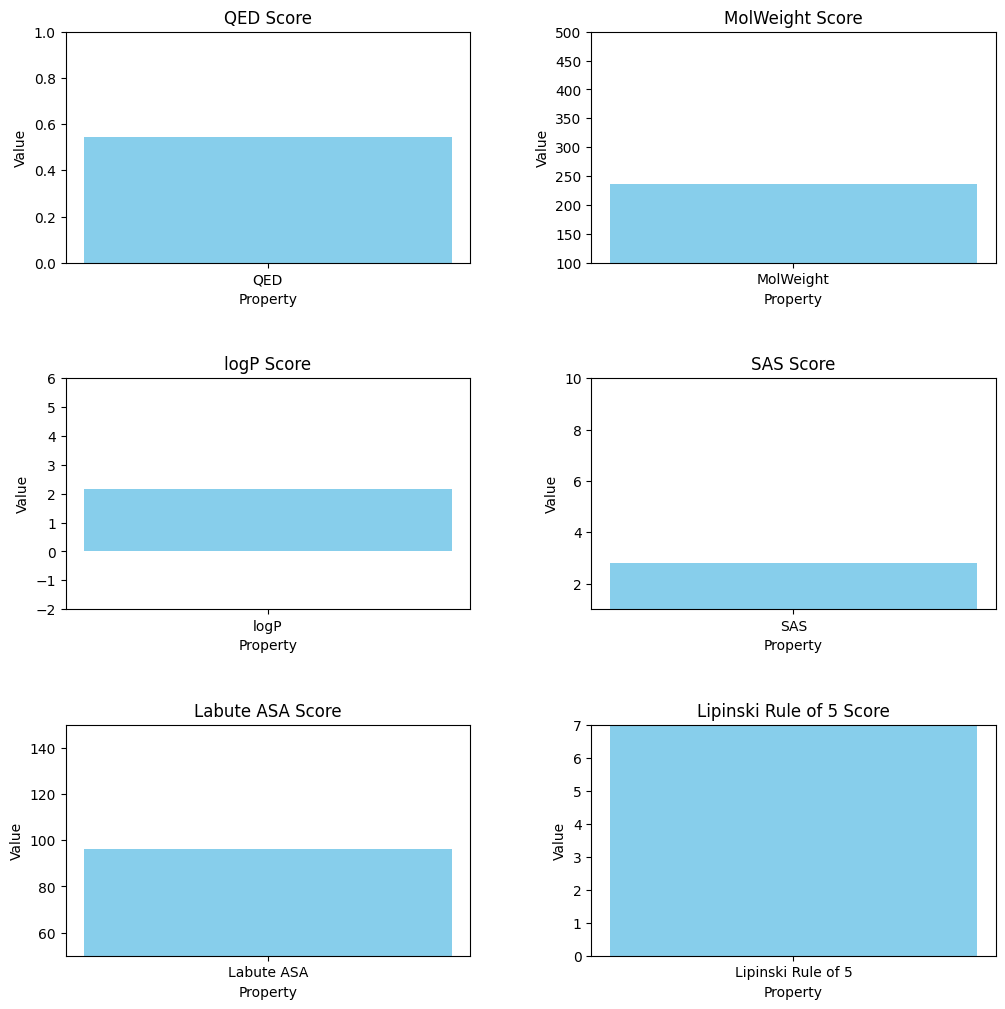

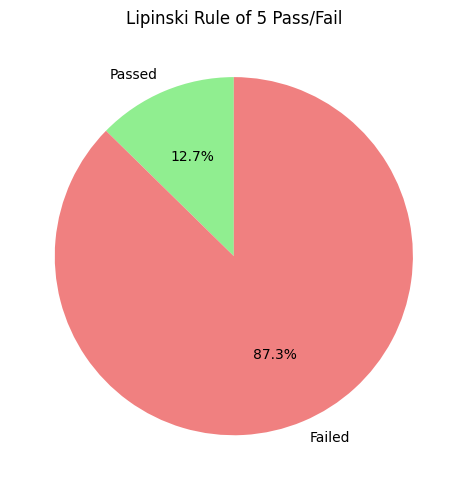

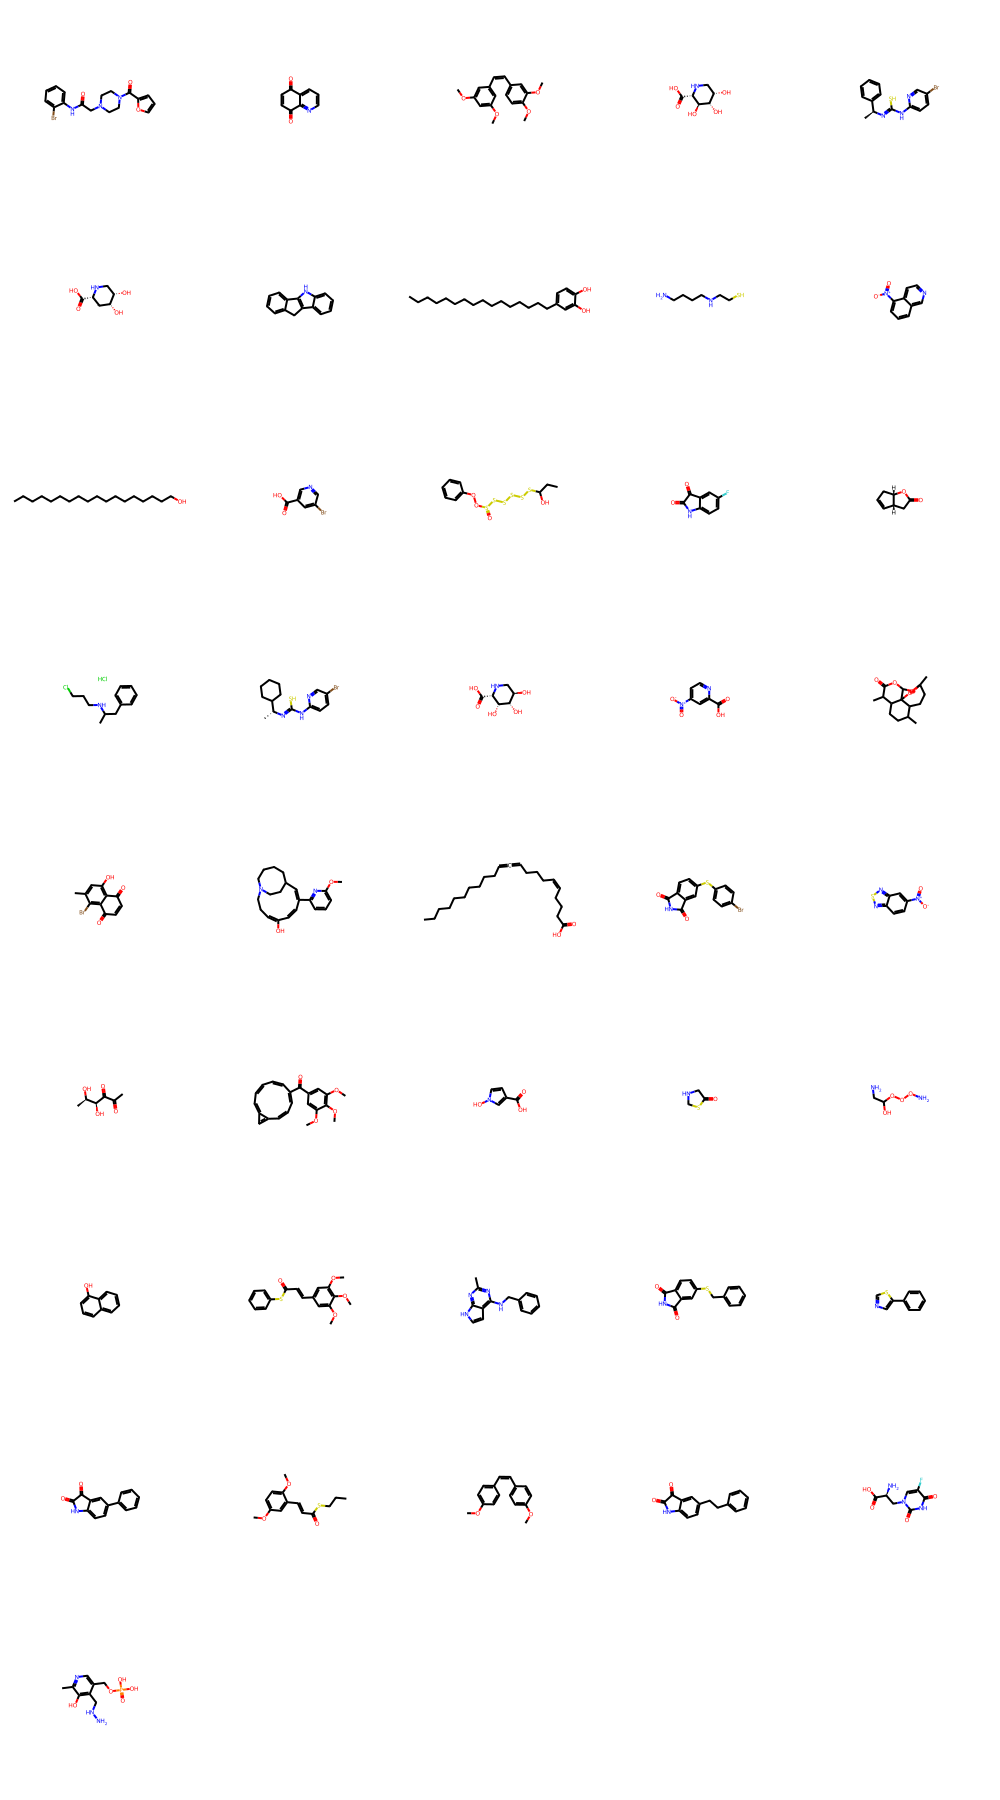

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from rdkit import Chem
from rdkit.Chem import Draw
import torch

def test_data(data_test):
    # Use to predict from data_test
    if type(data_test) == np.ndarray:
        data_test = torch.from_numpy(data_test)
    elif type(data_test) == h5py.Dataset:
        data_test = torch.from_numpy(np.array(data_test))
    elif type(data_test) == torch.Tensor:
        data_test = torch.from_numpy(data_test.numpy()).float()
    else:
        data_test = data_test.float()

    data_test = data_test.to(device)
    output, _, _ = model(data_test)

    # Decode the output
    out = output.cpu().detach().numpy()
    out = out.reshape(out.shape[0], input_len, charset_len).argmax(axis=2)
    decoded = []
    for i in range(out.shape[0]):
        decoded.append(decode_smiles_from_indexes(map(int, out[i]), charset))

    # Calculate performance metrics
    rdBase.DisableLog('rdApp.*')
    frac_valid, avg_mol_wt, avg_logP, avg_qed, avg_sas, avg_labute_asa, lipinski_count, avg_bbb_score = calculate_mol_metrics(decoded)

    # Print property metrics
    print(f'Fraction of valid molecules: {frac_valid}')
    print(f'Average molecular weight: {avg_mol_wt}')
    print(f'Average logP score: {avg_logP}')
    print(f'Average QED score: {avg_qed}')
    print(f'Average Synthetic Accessibility Score: {avg_sas}')
    print(f'Average Labute ASA score: {avg_labute_asa}')
    print(f'Total Lipinski Rule of 5 Passings: {lipinski_count}')
    print(f'# of BBB-P Passing: {avg_bbb_score}')

    # Properties and values for graphing
    properties = ['QED', 'MolWeight', 'logP', 'SAS', 'Labute ASA', 'Lipinski Rule of 5']
    values = [avg_qed, avg_mol_wt, avg_logP, avg_sas, avg_labute_asa, lipinski_count]

    # Plot each property in a separate graph
    fig, axs = plt.subplots(3, 2, figsize=(12, 12))
    axs = axs.ravel()  # Flatten the array of axes for easy iteration

    # Bar Graphs for Each Property
    for i, (prop, val) in enumerate(zip(properties, values)):
        axs[i].bar(prop, val, color='skyblue')
        axs[i].set_title(f'{prop} Score')
        axs[i].set_ylabel('Value')
        axs[i].set_xlabel('Property')

        # Dynamically adjust the y-axis limit for each property based on its value range
        y_max = max(values)
        if prop == 'QED':
            axs[i].set_ylim(0, 1)  # QED is typically between 0 and 1
        elif prop == 'MolWeight':
            axs[i].set_ylim(100, 500)  # Molecular weight typically between 100 and 500
        elif prop == 'logP':
            axs[i].set_ylim(-2, 6)  # logP is typically in this range
        elif prop == 'SAS':
            axs[i].set_ylim(1, 10)  # SAS score typically between 1 and 10
        elif prop == 'Labute ASA':
            axs[i].set_ylim(50, 150)  # Labute ASA typically falls in this range
        elif prop == 'Lipinski Rule of 5':
            axs[i].set_ylim(0, 7)  # Lipinski count usually ranges from 0 to 5
# Add more space between the subplots using plt.subplots_adjust()
    plt.subplots_adjust(hspace=0.5, wspace=0.3)  # Adjust vertical and horizontal spacing
    # Create Lipinski Pie Chart
    passed = lipinski_count  # Number of molecules passing Lipinski's Rule
    total = len(decoded)  # Total number of molecules sampled
    failed = total - passed  # Molecules that fail Lipinski's Rule

    # Create a pie chart showing the proportions of pass/fail for Lipinski Rule of 5
    fig_pie, ax_pie = plt.subplots(figsize=(5, 5))
    ax_pie.pie([passed, failed], labels=['Passed', 'Failed'], autopct='%1.1f%%', startangle=90, colors=['lightgreen', 'lightcoral'])
    ax_pie.set_title('Lipinski Rule of 5 Pass/Fail')

    plt.tight_layout()
    plt.show()

    # Draw the first 10 valid molecules
    valid_mols = [Chem.MolFromSmiles(s) for s in decoded if Chem.MolFromSmiles(s)]
    dr_mol = Draw.MolsToGridImage(valid_mols, molsPerRow=5, subImgSize=(200, 200))
    display(dr_mol)


# Example of running the test
if RUN_ON_TEST_DATA:
    test_data(data_test)

CALCULATE AND SHOW MOLECULES ORDERED WITH HIGHEST QUANTITAVE QED SCORE (Estimated Drug Likelihood)

In [ ]:
from rdkit import Chem
from rdkit.Chem import Descriptors, QED, rdBase
import numpy as np
import h5py

from rdkit import Chem
from rdkit.Chem import Descriptors, QED, rdBase

def calculate_mol_metrics(smiles):
    # Parse SMILES to molecules
    mols = [Chem.MolFromSmiles(s) for s in smiles]

    # Filter out invalid molecules
    valid_mols = [m for m in mols if m is not None]
    invalid_count = len(mols) - len(valid_mols)  # Track invalid molecules
    print(f'Num valid: {len(valid_mols)} out of {len(mols)} molecules')

    frac_valid = len(valid_mols) / len(mols) if len(mols) > 0 else 0  # Avoid division by zero

    # Calculate molecular weight for valid molecules only
    mol_wt = [Descriptors.MolWt(m) for m in valid_mols]
    avg_mol_wt = sum(mol_wt) / len(mol_wt) if mol_wt else 0

    # Calculate logP for valid molecules only
    logP = [Descriptors.MolLogP(m) for m in valid_mols]
    avg_logP = sum(logP) / len(logP) if logP else 0

    # Calculate QED score for valid molecules only
    qed_score = [QED.qed(m) for m in valid_mols]
    avg_qed = sum(qed_score) / len(qed_score) if qed_score else 0

    # Calculate Synthetic Accessibility Score for valid molecules only
    sas = [sascorer.calculateScore(m) for m in valid_mols]
    avg_sas = sum(sas) / len(sas) if sas else 0

    # Calculate Labute ASA score for valid molecules only
    labute_asa = [Descriptors.LabuteASA(m) for m in valid_mols]
    avg_labute_asa = sum(labute_asa) / len(labute_asa) if labute_asa else 0

    # Lipinski Rule of 5: Count molecules that pass at least 3 conditions
    lipinski_count = 0
    for m in valid_mols:
        MW = Descriptors.MolWt(m)
        HBA = Descriptors.NOCount(m)
        HBD = Descriptors.NHOHCount(m)
        LogP = Descriptors.MolLogP(m)
        conditions = [MW <= 500, HBA <= 10, HBD <= 5, LogP <= 5]
        if conditions.count(True) >= 3:
            lipinski_count += 1

    return frac_valid, avg_mol_wt, avg_logP, avg_qed, avg_sas, avg_labute_asa, lipinski_count

Original SMILES vs Sampled SMILES:
Original: CN(C)c1ncnc2c1ncn2CCn1cnc2ncnc(N(C)C)c21
Sampled: CN(CCcccccc(c2oc(Cc2c2)c2c2cc(C))c2)))c1

Original: CC1OC2(CS1)CN1CCC2CC1.Cl.O
Sampled: CCCNCC(2C2c2cCCCCCCC1CC2

Original: CCOC(=O)CC/N=C(\N)N=C(N)N.Cl.Cl
Sampled: CCOC(CO[C2]C(C)CCC)C())CCC(N)=C

Original: CN1CC=C(C=Cc2c[nH]c3ccccc23)CC1
Sampled: CNCCN(CNCCCCCcc2ccc3ccccc21CCCl

Original: CCCCCCCCCCCCC[C@@H](O)C[C@@H](O)[C@H](C)N
Sampled: CCCCCCCCCCCCC@@H](O)[[@@H]C@H]CC@H](O)N

Original: COc1ccc2nc(NC(=O)Nc3ccccc3)sc2c1
Sampled: COc1ccc2N(NN)=ccccc(F)cccncc22c1

Original: C1CCC2(CC1)COC1(CCCCC1)OC2
Sampled: C1CCC2(CCC1CCsC(CCCCCC1)O2

Original: O=C(CN1CCN(C(=O)c2ccco2)CC1)Nc1ccccc1Br
Sampled: O=C(CN1CCN(C(=O)c2ccco2)CC1)Nc1ccccc1Br

Original: O=C(/C=C\Nc1ccccn1)c1ccc(Cl)cc1
Sampled: O=C(NC(=C)c1cccCCCCCCCCCcccccc1

Original: CN(C)C(=O)CCNc1ccc(Br)cc1
Sampled: Cl.=/C((CC(=Occ1ccc(Clccc1C

Num valid: 41 out of 324 molecules
Fraction of valid molecules: 0.12654320987654322
Average molecular w

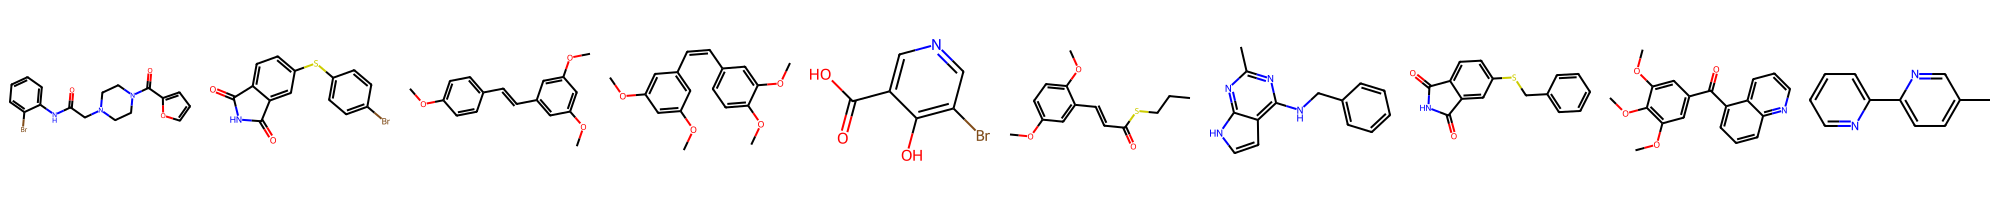

In [ ]:
from rdkit.Chem import Draw
from rdkit.Chem import MolFromSmiles
from rdkit import Chem
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
from rdkit.Chem import Draw

def generate_mol_image_with_qed(mol, qed_score):
    """Generate an image of a molecule with QED score below it."""
    # Generate the molecule image
    img = Draw.MolToImage(mol, size=(200, 200))

    # Convert the image to a format we can draw text on
    img = img.convert("RGBA")
    draw = ImageDraw.Draw(img)

    # Choose a font (you can modify the font size and style here)
    font = ImageFont.load_default()  # You can specify a TTF font file if desired
    text = f"QED: {qed_score:.3f}"  # Format the QED score

    # Define text position (just below the molecule image)
    text_position = (10, img.height - 20)  # Adjust as necessary
    draw.text(text_position, text, font=font, fill=(0, 0, 0))  # Draw text

    return img

from rdkit.Chem import Draw
from rdkit import Chem
from rdkit.Chem import QED

def test_data(data_test):
    # Use to predict from data_test
    if type(data_test) == np.ndarray:
        data_test = torch.from_numpy(data_test)
    elif type(data_test) == h5py.Dataset:
        data_test = torch.from_numpy(np.array(data_test))
    elif type(data_test) == torch.Tensor:
        data_test = torch.from_numpy(data_test.numpy()).float()
    else:
        data_test = data_test.float()

    data_test = data_test.to(device)
    output, _, _ = model(data_test)

    # Decode the output
    out = output.cpu().detach().numpy()
    out = out.reshape(out.shape[0], input_len, charset_len).argmax(axis=2)
    decoded = []
    for i in range(out.shape[0]):
        decoded.append(decode_smiles_from_indexes(map(int, out[i]), charset))

    # Print the first 10 decoded SMILES and the original (ground truth) data
    print("Original SMILES vs Sampled SMILES:")
    for i in range(10):
        # Print the decoded molecule (sampled by the model)
        decoded_smiles = decoded[i]
        # Convert one-hot encoded input data back to SMILES (original ground truth)
        original_smiles = decode_smiles_from_indexes(map(from_one_hot_array, data_test[i].cpu().numpy()), charset)

        # Print both original and sampled molecules
        print(f"Original: {original_smiles}")
        print(f"Sampled: {decoded_smiles}")
        print()

    # Calculate performance metrics
    rdBase.DisableLog('rdApp.*')
    frac_valid, avg_mol_wt, avg_logP, avg_qed, avg_sas, avg_labute_asa, lipinski_count = calculate_mol_metrics(decoded)

    print(f'Fraction of valid molecules: {frac_valid}')
    print(f'Average molecular weight: {avg_mol_wt}')
    print(f'Average logP score: {avg_logP}')
    print(f'Average QED score: {avg_qed}')
    print(f'Average Synthetic Accessibility Score: {avg_sas}')
    print(f'Average Labute ASA score: {avg_labute_asa}')
    print(f'Total Lipinski Rule of 5 Passings: {lipinski_count}')

    # Draw the first 10 valid molecules with their QED scores
    valid_mols_with_qed = []
    for smi in decoded:
        mol = Chem.MolFromSmiles(smi)
        if mol:  # Only add valid molecules
            qed = QED.qed(mol)
            valid_mols_with_qed.append((mol, qed))

    # Sort by QED score (highest first)
    valid_mols_with_qed.sort(key=lambda x: x[1], reverse=True)

    # Take the top 10 molecules (highest QED)
    top_10_valid_mols = valid_mols_with_qed[:10]

    # Display the molecules in a grid
    mol_images = []
    for mol, qed in top_10_valid_mols:  # Top 10 molecules
        img = Draw.MolToImage(mol, size=(200, 200))
        mol_images.append(img)

    # Create a grid image of the molecules
    if mol_images:
        img_grid = Image.new('RGBA', (200 * len(mol_images), 200))
        for i, img in enumerate(mol_images):
            img_grid.paste(img, (i * 200, 0))

        # Display the final image
        display(img_grid)





# Assuming `RUN_ON_TEST_DATA` is set to `True`, run the test
if RUN_ON_TEST_DATA:
    test_data(data_test)


Blood Brain Barrier Analysis

SUGGEST NEW MOLECULES FROM LATENT SPACE

In [ ]:
# Suggest new molecules from latent space, validate, and calculate metrics
def suggest_molecules(model, num_mols=1000):
    z = torch.randn(num_mols, 292).to(device)
    output = model.decode(z)
    out = output.cpu().detach().numpy()
    out = out.reshape(out.shape[0], input_len, charset_len).argmax(axis=2)
    decoded = []
    for i in range(out.shape[0]):
        # get charset in correct format from array of strings
        decoded.append(decode_smiles_from_indexes(map(int, out[i]), charset))

    frac_valid, avg_mol_wt, avg_logP, avg_qed, avg_sas, avg_labute_asa, lipinski_count = calculate_mol_metrics(decoded)
    print(f'Fraction of valid molecules: {frac_valid}')
    print(f'Average molecular weight: {avg_mol_wt}')
    print(f'Average logP score: {avg_logP}')
    print(f'Average QED score: {avg_qed}')
    print(f'Average Synthetic Accessibility Score: {avg_sas}')
    print(f'Average Labute ASA score: {avg_labute_asa}')
    print(f'Total Lipinski Rule of 5 Passings: {lipinski_count}')

    # Draw the first 10 valid molecules
    valid_mols = [Chem.MolFromSmiles(s) for s in decoded if Chem.MolFromSmiles(s)]
    print([d for d in decoded if Chem.MolFromSmiles(d)])
    dr_mol = Draw.MolsToGridImage(valid_mols, molsPerRow=5, subImgSize=(200, 200))
    display(dr_mol)

    return decoded

Num valid: 17 out of 1000 molecules
Fraction of valid molecules: 0.017
Average molecular weight: 203.11623529411767
Average logP score: 3.529795294117648
Average QED score: 0.4918863134148985
Average Synthetic Accessibility Score: 3.2753601033933926
Average Labute ASA score: 89.40243850506754
Total Lipinski Rule of 5 Passings: 17
['Cc1cc2ccccccccccccc12', 'Oc1ccc2cccccccccccc12', 'Clc1c(C)ccccnncnn2cccccc12', 'NCSSS', 'CCCc1cc(O)ccc(O)cc1', 'N', 'Cl', 'CCCCCCc1ccc(CC(O))cc1', 'CC(C(=O)O)c1ccc(OC(O)O)cc1', 'CC', 'CC/CCCCCCC=C/CCC/C=C/CCC\\C/CCCC\\CCC(=O)O', 'Cc1ccccccccccc1N', 'CCCCc1ccccc1O', 'c1ccc2ccccccc2ccc1', 'CCCCCCCCCCCCCCCCCCCCCCCCCC(C)CCCC(OO)O', 'COc1ccccc1OCCCCCCCCCC1CC1', 'CCC(C(C(COC)C(C)CC=O)C(C))OO']


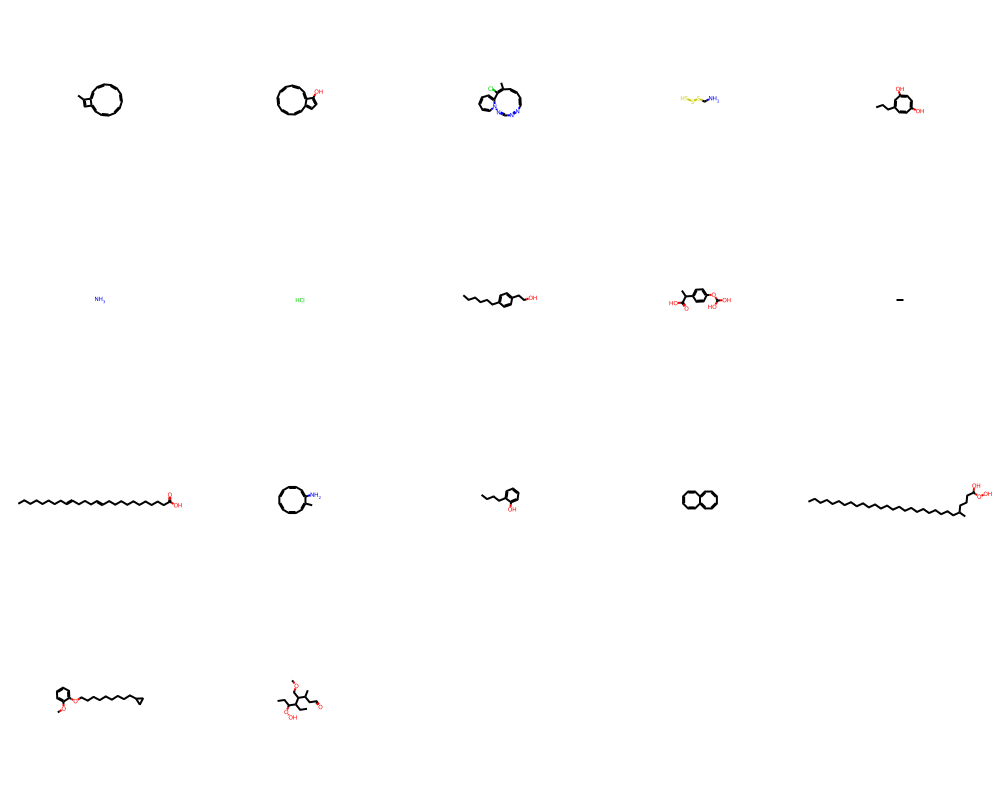

In [ ]:
if GENERATE_LATENT_SPACE_SMILES:
    # suggest new molecules and calculate metrics
    suggest_molecules(model)

other stuff

In [ ]:
# Predict smiles based on these external smiles as input
# Use model to predict and then evaluate the predicted molecules
import data_preprocessing as dp

# Evaluate other Smiles generated from external sources using this model
# Vocab must be less than or equal to charset_len for this model

def display_sample_smiles(smiles_file_path):

    # import sample smiles from SMILES_Dataset.csv
    smiles_data = pd.read_csv(smiles_file_path, header=0)
    # remove empty rows
    smiles_data = smiles_data.dropna()

    # evaluate sample smiles for validity and molecular weight
    frac_valid, avg_mol_wt = calculate_mol_metrics(smiles_data['Smiles'])
    print(f'Fraction of valid molecules: {frac_valid}')
    print(f'Average molecular weight: {avg_mol_wt}')

    # Draw the first 20 valid molecules
    valid_mols = [Chem.MolFromSmiles(s) for s in smiles_data['Smiles'] if Chem.MolFromSmiles(s)]
    print(f"Valid smiles: {[d for d in smiles_data['Smiles'] if Chem.MolFromSmiles(d)]}")
    dr_mol = Draw.MolsToGridImage(valid_mols[:40], molsPerRow=5, subImgSize=(200, 200))
    print('Displaying input Sample Smiles: ')
    display(dr_mol)

    # send in charset_len
    # get h5 file from data_preprocessing
    data_path = dp.original_csv_to_ohe_h5(smiles_file_path, max_smiles_len=input_len, charset=charset)

    # load the data
    data_test, _ = load_dataset(data_path, split=False)

    # Use to predict from data_test
    if type(data_test) == np.ndarray:
        data_test = torch.from_numpy(data_test)
    elif type(data_test) == h5py.Dataset:
        data_test = torch.from_numpy(np.array(data_test))
    elif type(data_test) == torch.Tensor:
        data_test = torch.from_numpy(data_test.numpy()).float()
    else:
        data_test = data_test.float()

    data_test = data_test.to(device)

    output, _, _ = model(data_test)
    out = output.cpu().detach().numpy()
    out = out.reshape(out.shape[0], input_len, charset_len).argmax(axis=2)
    decoded = []
    for i in range(out.shape[0]):
        decoded.append(decode_smiles_from_indexes(map(int, out[i]), charset))

    # print the first 10 decoded SMILES and the test data
        print()
        print(f'Original: {smiles_data["Smiles"].iloc[i]}')
        print(f'Predicted: {decoded[i]}')

    # calculate performance metrics
    rdBase.DisableLog('rdApp.*')
    try:
        frac_valid, avg_mol_wt = calculate_mol_metrics(decoded)
        print(f'Fraction of valid molecules: {frac_valid}')
        print(f'Average molecular weight: {avg_mol_wt}')

        # Draw the first 10 valid molecules
        valid_mols = [Chem.MolFromSmiles(s) for s in decoded if Chem.MolFromSmiles(s)]
        print([d for d in decoded if Chem.MolFromSmiles(d)])
        dr_mol = Draw.MolsToGridImage(valid_mols, molsPerRow=5, subImgSize=(200, 200))
        print('Displaying Model Predicted Smiles from Sample Smiles as input:')
        display(dr_mol)
    except ZeroDivisionError:
        print('No valid molecules found')

In [ ]:
if EVAL_OTHER_SMILES:
    smiles_file_path = 'drive/My Drive/data/SMILES_Dataset.csv'
    display_sample_smiles(smiles_file_path)